# H$_\alpha$ and [OIII] correlations


In this notebook I focus on the comparison of the CIGALE outputs for SFR in the COSMOS and GOODS-S field mainly using the H$_\alpha$ and the [OIII] lines. 

The CIGALE outputs will be taken as the best models based on the work of B. Argence & F. Lamareille., 2009 where they compared CL01 models to dusta attenuation corrected SFRs using H$_\alpha$ as in Keniccutt., 1998, a proposed power law, single-line and double-line calibrations when no dust information is available.

Following Suzuki et al., 2016 we can also compare to the beta-slope method.However, they separated the samples in three different ones due to the fact that [OIII] emitters somehow are biased in comparison to H$_\alpha$ to larger sSFRuv. 

I will use a combination of both methods to study my sample in which I plan to use CIGALE as the correct method and compare it to all the possible versions. Also splitting the whole sample into different emitters to see if something is changes.

I will exclude the AGN sources by: 
                                   
                                   i) comparing to CIGALE agn_frac

                                   ii) using the IRAC bands method, or/and 
                                   
                                   iii) simply excluding all the x-ray data

In [1]:
# Regular packages

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, Column
# from astropy.io import ascii
import os
from matplotlib.legend_handler import HandlerPathCollection
import pandas as pd
import scipy.integrate as integrate
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
# import warnings
# warnings.filterwarnings('ignore')

%matplotlib inline

# Functions

In [2]:
# Functions
#--------------------------------------------------------

# Values taken from https://arxiv.org/pdf/1807.06209.pdf
H0 = 2.184e-21 # km s^−1 m^−1 (67.4 km s^−1 Mpc^−1)
c  = 2.99792e5 # km s^−1
Om = 0.315
Ol = 1.0 - Om

# Line-emission luminosity
def flux_to_luminosity(flux, z ,Om, Ol, c, H0):
    
    luminosity = []
    for i in range(len(flux)):
        
        d = (c/H0)*(1.0 + z[i])
    
        integral = integrate.quad(lambda x: ((1.0 + x)**2*(1.0 + Om*x) - Ol*x*(2.0 + x))**(-1.0/2.0), 0.0, z[i])
    
        L = 4.0*np.pi*( d*integral[0] )**2*flux[i]
        
        luminosity.append(L*1e7)
    
    return(np.array(luminosity)) # From Watts/cm^2 to erg s^-1


#Attenuation for a given line
#DBPL-like models
def A_line(A_v, Lambda, Lambda_v, n):
    return (A_v * (Lambda/Lambda_v)**n)

#Error in attenuation for a given line
#DBPL-like models
def Attenuation_DBPL_err(A_halpha, L, Lv, n, n_err, Av, Av_err):
    return (A_halpha)**2 * ((Av_err**2/Av**2) + (n**2*(np.log(L/Lv))**2*n_err**2)/(L/Lv)**(2*n))

#Power law exponent between two wavelengths (l and v)
def power_law_exponent(A_l, A_v, l, v):
    return (np.log(A_l/A_v) / np.log(l/v))

# Data

In [72]:
# Files used here need to be the most general one using the modified recipes and varying everything for the plots

In [3]:
# Data with all the info
# This data is the one with all the info before creating the Original data which was used in CIGALE

COSMOS          = Table.read('/data/FMOS_Laigle/CIGALE-results/COSMOS_CIGALE_BPTsubsample_2019.fits', format = 'fits')

#Calzetti
COSMOS_cigale_1 = Table.read('/data/FMOS_Laigle/CIGALE-results/results_1.txt', format = 'ascii')
#starburst-modified
COSMOS_cigale_2 = Table.read('/data/FMOS_Laigle/CIGALE-results/results_2.txt', format = 'ascii')

#CF00
COSMOS_cigale_3 = Table.read('/data/FMOS_Laigle/CIGALE-results/results_3.txt', format = 'ascii')
# #CF00-modified
# COSMOS_cigale_4 = Table.read('/data/FMOS_Laigle/CIGALE-results/results_4.txt', format = 'ascii')

# Redshift distribution for the cleaned AGN-sample

In [4]:
# Limits for the emission lines detected in WFC3 G141 (11000-16500 A)

def redshift_range(L_obs, L_emit):
    return (abs(L_obs - L_emit)/L_emit)

emission_lines = np.array([6563, 4861, 3729.875, 5007]) #In Angstrom for Ha, Hb, OII, OIII
z_low          = redshift_range(11000, emission_lines)
z_high         = redshift_range(16500, emission_lines) 

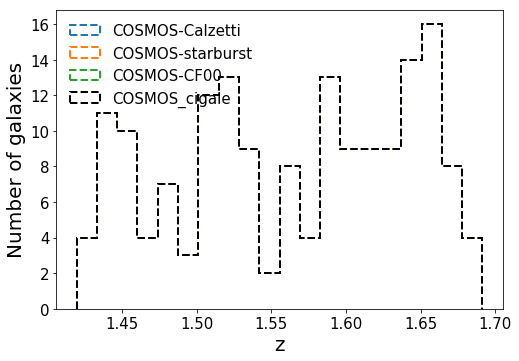

In [5]:
plt.figure(figsize = (8,5.5))
plt.hist(COSMOS_cigale_1['best.universe.redshift'], bins = 20, histtype = 'step', lw = 2, ls = '--', label = 'COSMOS-Calzetti', color = 'C0')
plt.hist(COSMOS_cigale_2['best.universe.redshift'], bins = 20, histtype = 'step', lw = 2, ls = '--', label = 'COSMOS-starburst', color = 'C1')
plt.hist(COSMOS_cigale_3['best.universe.redshift'], bins = 20, histtype = 'step', lw = 2, ls = '--', label = 'COSMOS-CF00', color = 'C2')
plt.hist(COSMOS['redshift'], bins = 20, histtype = 'step', lw = 2, ls = '--', label = 'COSMOS_cigale', color = 'k')
plt.xlabel('z', fontsize = 20)
plt.ylabel('Number of galaxies', fontsize = 20)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.legend(frameon = False, prop = {'size': 15}, markerscale = 1.5 , loc = 'upper left')

# H$_\alpha$ and [OIII] fitting with CIGALE
# Recipes
### dustatt_modified_starburst and dustatt_modified_CF00

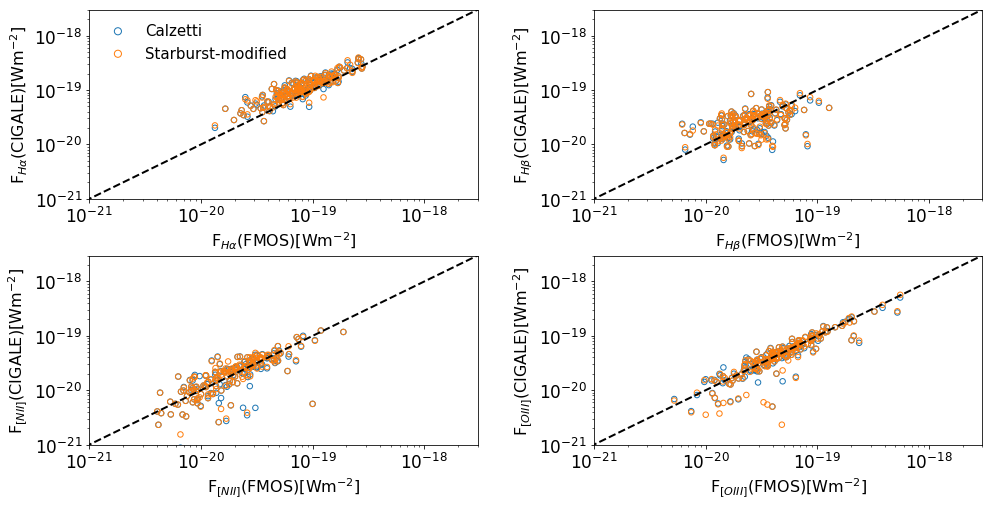

In [76]:
X_1 = np.linspace(0.0,9.0,100)

fig, ((axA, axB), (axC, axD)) = plt.subplots(figsize=(16,8), nrows=2, ncols=2)
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

axA.scatter(COSMOS['line.H-alpha'],\
            COSMOS_cigale_1['best.line.H-alpha'], marker = 'o', s = 30,\
            facecolor = 'none', edgecolors = 'C0', label = 'Calzetti')
axA.scatter(COSMOS['line.H-alpha'],\
            COSMOS_cigale_2['best.line.H-alpha'], marker = 'o', s = 30,\
            facecolor = 'none', edgecolors = 'C1', label = 'Starburst-modified')
#axA.scatter(GOODSS_sample['line.NII-654.8+line.H-alpha+line.NII-658.4'],\
#            GOODSS_CF00_results['best.line.NII-654.8+line.H-alpha+line.NII-658.4'], marker = 'o', s = 30,\
#            facecolor = 'none', edgecolors = 'C1', label = 'GOODSS - CF00 - All')
axA.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axA.set_xlim(1e-21, 3e-18)
axA.set_ylim(1e-21, 3e-18)
axA.set_xscale('log')
axA.set_yscale('log')
axA.set_xlabel(r'F$_{H\alpha}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axA.set_ylabel(r'F$_{H\alpha}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axA.tick_params(axis = 'both', which = 'major', labelsize = 17)
axA.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'upper left')

axB.scatter(COSMOS['line.H-beta'],\
            COSMOS_cigale_1['best.line.H-beta'], marker = 'o', s = 30,\
            facecolor = 'none', edgecolors = 'C0')
axB.scatter(COSMOS['line.H-beta'],\
            COSMOS_cigale_2['best.line.H-beta'], marker = 'o', s = 30,\
            facecolor = 'none', edgecolors = 'C1')
#axB.scatter(GOODSS_sample['line.OIII-500.7'],\
#            GOODSS_CF00_results['best.line.OIII-500.7'], marker = 'o', s = 30,\
#            facecolor = 'none', edgecolors = 'C1', label = 'GOODSS - CF00 - All')
axB.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axB.set_xlim(1e-21, 3e-18)
axB.set_ylim(1e-21, 3e-18)
axB.set_xscale('log')
axB.set_yscale('log')
axB.set_xlabel(r'F$_{H\beta}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axB.set_ylabel(r'F$_{H\beta}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axB.tick_params(axis = 'both', which = 'major', labelsize = 17)
#axB.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'upper left')

axC.scatter(COSMOS['line.NII-658.4'],\
            COSMOS_cigale_1['best.line.NII-658.4'], marker = 'o', s = 30,\
            facecolor = 'none', edgecolors = 'C0')
axC.scatter(COSMOS['line.NII-658.4'],\
            COSMOS_cigale_2['best.line.NII-658.4'], marker = 'o', s = 30,\
            facecolor = 'none', edgecolors = 'C1')
#axC.scatter(GOODSS_sample['line.NII-654.8+line.H-alpha+line.NII-658.4'],\
#            GOODSS_starburst_results['best.line.NII-654.8+line.H-alpha+line.NII-658.4'], marker = 'o', s = 30,\
#            facecolor = 'none', edgecolors = 'C1', label = 'GOODSS - starburst - All')
axC.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axC.set_xlim(1e-21, 3e-18)
axC.set_ylim(1e-21, 3e-18)
axC.set_xscale('log')
axC.set_yscale('log')
axC.set_xlabel(r'F$_{[NII]}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axC.set_ylabel(r'F$_{[NII]}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axC.tick_params(axis = 'both', which = 'major', labelsize = 17)
#axC.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'upper left')

axD.scatter(COSMOS['line.OIII-500.7'],\
            COSMOS_cigale_1['best.line.OIII-500.7'], marker = 'o', s = 30,\
            facecolor = 'none', edgecolors = 'C0')
axD.scatter(COSMOS['line.OIII-500.7'],\
            COSMOS_cigale_2['best.line.OIII-500.7'], marker = 'o', s = 30,\
            facecolor = 'none', edgecolors = 'C1')
#axD.scatter(GOODSS_sample['line.OIII-500.7'],\
#            GOODSS_starburst_results['best.line.OIII-500.7'], marker = 'o', s = 30,\
#            facecolor = 'none', edgecolors = 'C1', label = 'GOODSS starburst - All')
axD.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axD.set_xlim(1e-21, 3e-18)
axD.set_ylim(1e-21, 3e-18)
axD.set_xscale('log')
axD.set_yscale('log')
axD.set_xlabel(r'F$_{[OIII]}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axD.set_ylabel(r'F$_{[OIII]}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axD.tick_params(axis = 'both', which = 'major', labelsize = 17)
#axD.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'upper left')

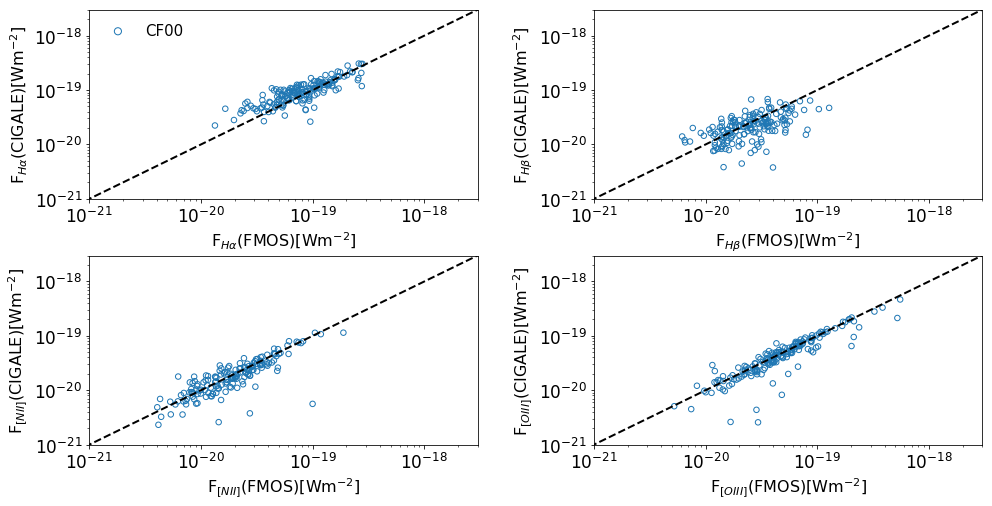

In [77]:
X_1 = np.linspace(0.0,9.0,100)

fig, ((axA, axB), (axC, axD)) = plt.subplots(figsize=(16,8), nrows=2, ncols=2)
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

axA.scatter(COSMOS['line.H-alpha'],\
            COSMOS_cigale_3['best.line.H-alpha'], marker = 'o', s = 30,\
            facecolor = 'none', edgecolors = 'C0', label = 'CF00')
# axA.scatter(COSMOS['line.H-alpha'],\
#             COSMOS_cigale_4['best.line.H-alpha'], marker = 'o', s = 30,\
#             facecolor = 'none', edgecolors = 'C1', label = 'CF00-modified')
axA.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axA.set_xlim(1e-21, 3e-18)
axA.set_ylim(1e-21, 3e-18)
axA.set_xscale('log')
axA.set_yscale('log')
axA.set_xlabel(r'F$_{H\alpha}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axA.set_ylabel(r'F$_{H\alpha}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axA.tick_params(axis = 'both', which = 'major', labelsize = 17)
axA.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'upper left')

axB.scatter(COSMOS['line.H-beta'],\
            COSMOS_cigale_3['best.line.H-beta'], marker = 'o', s = 30,\
            facecolor = 'none', edgecolors = 'C0')
# axB.scatter(COSMOS['line.H-beta'],\
#             COSMOS_cigale_4['best.line.H-beta'], marker = 'o', s = 30,\
#             facecolor = 'none', edgecolors = 'C1')
axB.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axB.set_xlim(1e-21, 3e-18)
axB.set_ylim(1e-21, 3e-18)
axB.set_xscale('log')
axB.set_yscale('log')
axB.set_xlabel(r'F$_{H\beta}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axB.set_ylabel(r'F$_{H\beta}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axB.tick_params(axis = 'both', which = 'major', labelsize = 17)

axC.scatter(COSMOS['line.NII-658.4'],\
            COSMOS_cigale_3['best.line.NII-658.4'], marker = 'o', s = 30,\
            facecolor = 'none', edgecolors = 'C0')
# axC.scatter(COSMOS['line.NII-658.4'],\
#             COSMOS_cigale_4['best.line.NII-658.4'], marker = 'o', s = 30,\
#             facecolor = 'none', edgecolors = 'C1')
axC.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axC.set_xlim(1e-21, 3e-18)
axC.set_ylim(1e-21, 3e-18)
axC.set_xscale('log')
axC.set_yscale('log')
axC.set_xlabel(r'F$_{[NII]}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axC.set_ylabel(r'F$_{[NII]}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axC.tick_params(axis = 'both', which = 'major', labelsize = 17)

axD.scatter(COSMOS['line.OIII-500.7'],\
            COSMOS_cigale_3['best.line.OIII-500.7'], marker = 'o', s = 30,\
            facecolor = 'none', edgecolors = 'C0')
# axD.scatter(COSMOS['line.OIII-500.7'],\
#             COSMOS_cigale_4['best.line.OIII-500.7'], marker = 'o', s = 30,\
#             facecolor = 'none', edgecolors = 'C1')
axD.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axD.set_xlim(1e-21, 3e-18)
axD.set_ylim(1e-21, 3e-18)
axD.set_xscale('log')
axD.set_yscale('log')
axD.set_xlabel(r'F$_{[OIII]}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axD.set_ylabel(r'F$_{[OIII]}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axD.tick_params(axis = 'both', which = 'major', labelsize = 17)

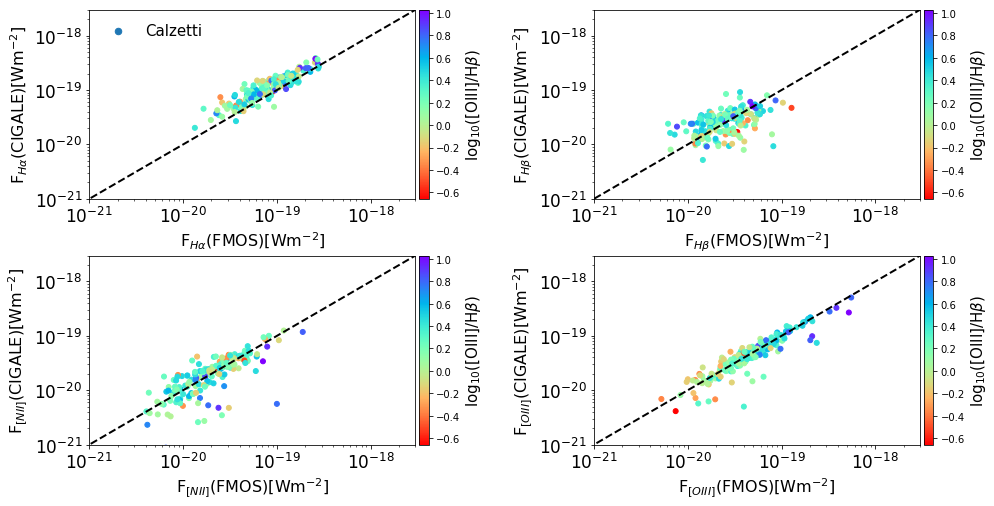

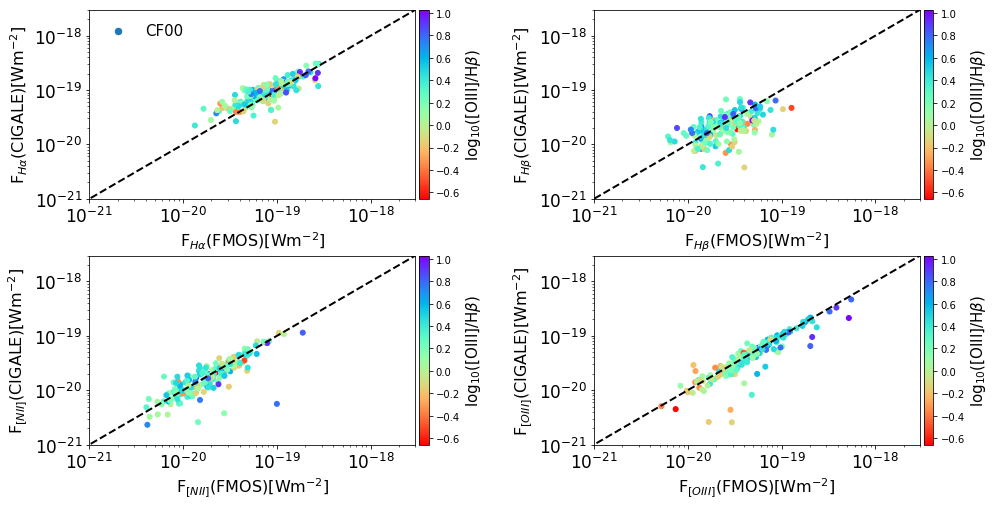

In [78]:
X_1 = np.linspace(0.0,9.0,100)

fig, ((axA, axB), (axC, axD)) = plt.subplots(figsize=(16,8), nrows=2, ncols=2)
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

img1 = axA.scatter(COSMOS['line.H-alpha'], COSMOS_cigale_1['best.line.H-alpha'], \
                  s = 25, c = np.log10(COSMOS['line.OIII-500.7']/COSMOS['line.H-beta']),\
                  cmap = plt.cm.rainbow_r, label = 'Calzetti')
ca = fig.colorbar(img1, ax=axA, pad = 0.01)
ca.set_label(label = r'log$_{10}$([OIII]/H$\beta$)', size = 15)
axA.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axA.set_xlim(1e-21, 3e-18)
axA.set_ylim(1e-21, 3e-18)
axA.set_xscale('log')
axA.set_yscale('log')
axA.set_xlabel(r'F$_{H\alpha}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axA.set_ylabel(r'F$_{H\alpha}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axA.tick_params(axis = 'both', which = 'major', labelsize = 17)
axA.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'upper left')

img2 = axB.scatter(COSMOS['line.H-beta'], COSMOS_cigale_1['best.line.H-beta'],\
                   s = 25, c = np.log10(COSMOS['line.OIII-500.7']/COSMOS['line.H-beta']),\
                   cmap = plt.cm.rainbow_r)
cb = fig.colorbar(img2, ax=axB, pad = 0.01)
cb.set_label(label = r'log$_{10}$([OIII]/H$\beta$)', size = 15)
axB.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axB.set_xlim(1e-21, 3e-18)
axB.set_ylim(1e-21, 3e-18)
axB.set_xscale('log')
axB.set_yscale('log')
axB.set_xlabel(r'F$_{H\beta}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axB.set_ylabel(r'F$_{H\beta}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axB.tick_params(axis = 'both', which = 'major', labelsize = 17)

img3 = axC.scatter(COSMOS['line.NII-658.4'], COSMOS_cigale_1['best.line.NII-658.4'],\
                   s = 25, c = np.log10(COSMOS['line.OIII-500.7']/COSMOS['line.H-beta']),\
                   cmap = plt.cm.rainbow_r)
cc = fig.colorbar(img3, ax=axC, pad = 0.01)
cc.set_label(label = r'log$_{10}$([OIII]/H$\beta$)', size = 15)
axC.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axC.set_xlim(1e-21, 3e-18)
axC.set_ylim(1e-21, 3e-18)
axC.set_xscale('log')
axC.set_yscale('log')
axC.set_xlabel(r'F$_{[NII]}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axC.set_ylabel(r'F$_{[NII]}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axC.tick_params(axis = 'both', which = 'major', labelsize = 17)

img4 = axD.scatter(COSMOS['line.OIII-500.7'], COSMOS_cigale_1['best.line.OIII-500.7'],\
                   s = 25, c = np.log10(COSMOS['line.OIII-500.7']/COSMOS['line.H-beta']),\
                   cmap = plt.cm.rainbow_r)
cd = fig.colorbar(img4, ax=axD, pad = 0.01)
cd.set_label(label = r'log$_{10}$([OIII]/H$\beta$)', size = 15)
axD.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axD.set_xlim(1e-21, 3e-18)
axD.set_ylim(1e-21, 3e-18)
axD.set_xscale('log')
axD.set_yscale('log')
axD.set_xlabel(r'F$_{[OIII]}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axD.set_ylabel(r'F$_{[OIII]}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axD.tick_params(axis = 'both', which = 'major', labelsize = 17)

# --------------------------------------------------------------------------------------------------------------------

fig, ((axA, axB), (axC, axD)) = plt.subplots(figsize=(16,8), nrows=2, ncols=2)
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

img1 = axA.scatter(COSMOS['line.H-alpha'], COSMOS_cigale_3['best.line.H-alpha'], \
                  s = 25, c = np.log10(COSMOS['line.OIII-500.7']/COSMOS['line.H-beta']),\
                  cmap = plt.cm.rainbow_r, label = 'CF00')
ca = fig.colorbar(img1, ax=axA, pad = 0.01)
ca.set_label(label = r'log$_{10}$([OIII]/H$\beta$)', size = 15)
axA.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axA.set_xlim(1e-21, 3e-18)
axA.set_ylim(1e-21, 3e-18)
axA.set_xscale('log')
axA.set_yscale('log')
axA.set_xlabel(r'F$_{H\alpha}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axA.set_ylabel(r'F$_{H\alpha}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axA.tick_params(axis = 'both', which = 'major', labelsize = 17)
axA.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'upper left')

img2 = axB.scatter(COSMOS['line.H-beta'], COSMOS_cigale_3['best.line.H-beta'],\
                   s = 25, c = np.log10(COSMOS['line.OIII-500.7']/COSMOS['line.H-beta']),\
                   cmap = plt.cm.rainbow_r)
cb = fig.colorbar(img2, ax=axB, pad = 0.01)
cb.set_label(label = r'log$_{10}$([OIII]/H$\beta$)', size = 15)
axB.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axB.set_xlim(1e-21, 3e-18)
axB.set_ylim(1e-21, 3e-18)
axB.set_xscale('log')
axB.set_yscale('log')
axB.set_xlabel(r'F$_{H\beta}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axB.set_ylabel(r'F$_{H\beta}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axB.tick_params(axis = 'both', which = 'major', labelsize = 17)

img3 = axC.scatter(COSMOS['line.NII-658.4'], COSMOS_cigale_3['best.line.NII-658.4'],\
                   s = 25, c = np.log10(COSMOS['line.OIII-500.7']/COSMOS['line.H-beta']),\
                   cmap = plt.cm.rainbow_r)
cc = fig.colorbar(img3, ax=axC, pad = 0.01)
cc.set_label(label = r'log$_{10}$([OIII]/H$\beta$)', size = 15)
axC.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axC.set_xlim(1e-21, 3e-18)
axC.set_ylim(1e-21, 3e-18)
axC.set_xscale('log')
axC.set_yscale('log')
axC.set_xlabel(r'F$_{[NII]}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axC.set_ylabel(r'F$_{[NII]}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axC.tick_params(axis = 'both', which = 'major', labelsize = 17)

img4 = axD.scatter(COSMOS['line.OIII-500.7'], COSMOS_cigale_3['best.line.OIII-500.7'],\
                   s = 25, c = np.log10(COSMOS['line.OIII-500.7']/COSMOS['line.H-beta']),\
                   cmap = plt.cm.rainbow_r)
cd = fig.colorbar(img4, ax=axD, pad = 0.01)
cd.set_label(label = r'log$_{10}$([OIII]/H$\beta$)', size = 15)
axD.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axD.set_xlim(1e-21, 3e-18)
axD.set_ylim(1e-21, 3e-18)
axD.set_xscale('log')
axD.set_yscale('log')
axD.set_xlabel(r'F$_{[OIII]}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axD.set_ylabel(r'F$_{[OIII]}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axD.tick_params(axis = 'both', which = 'major', labelsize = 17)

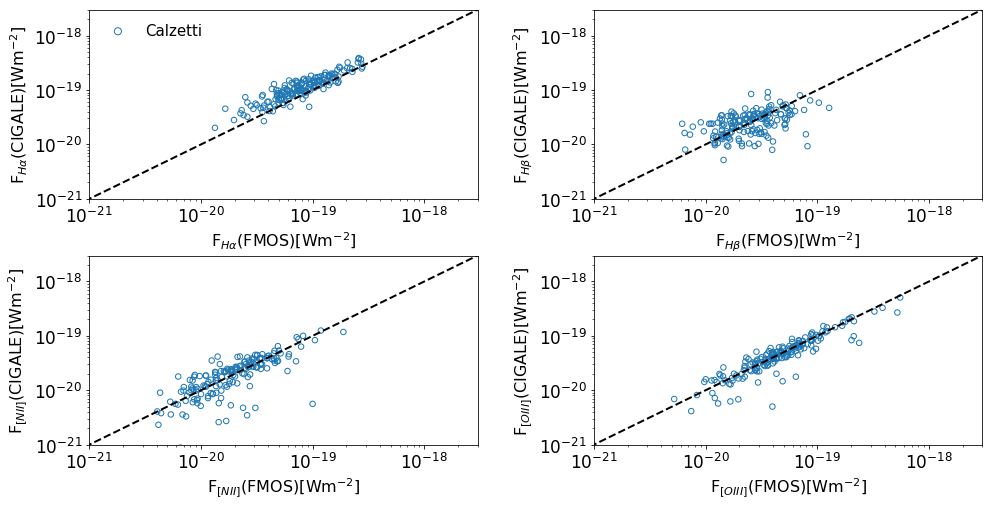

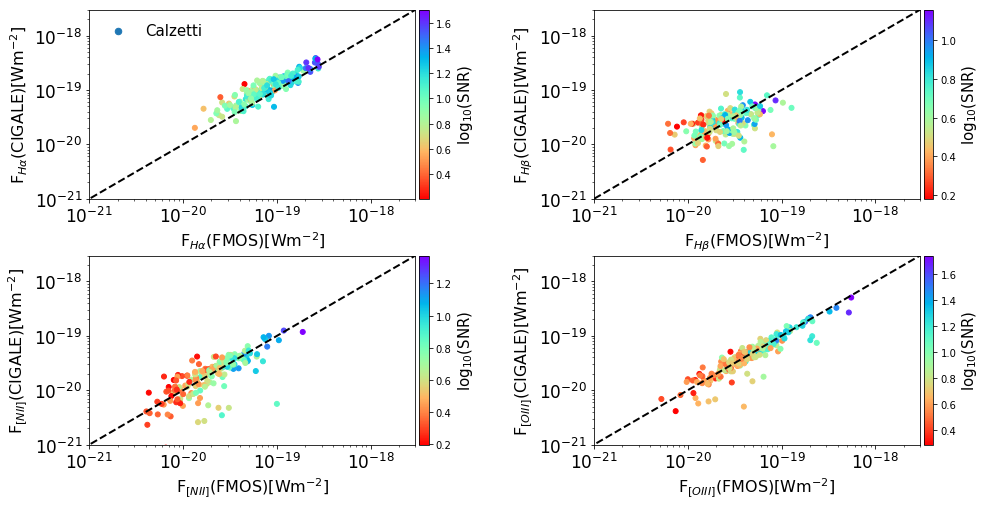

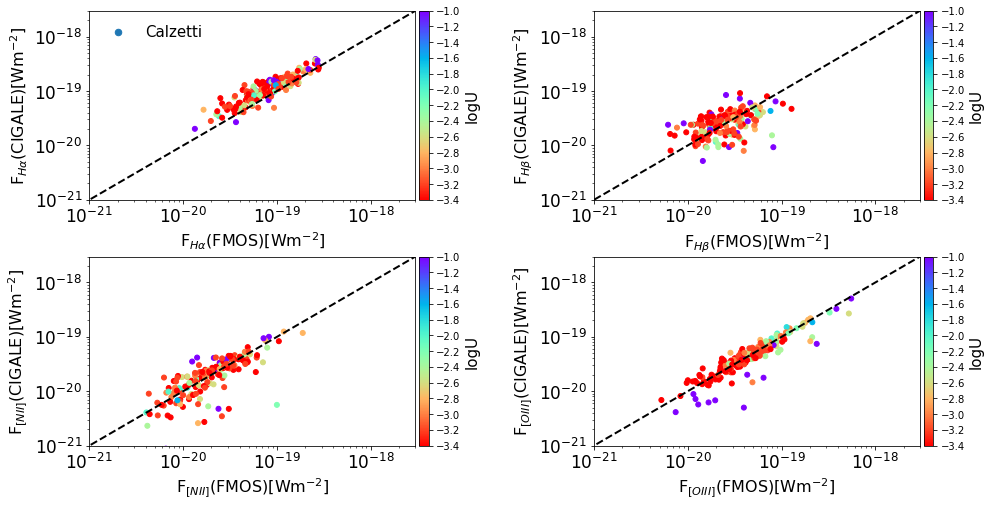

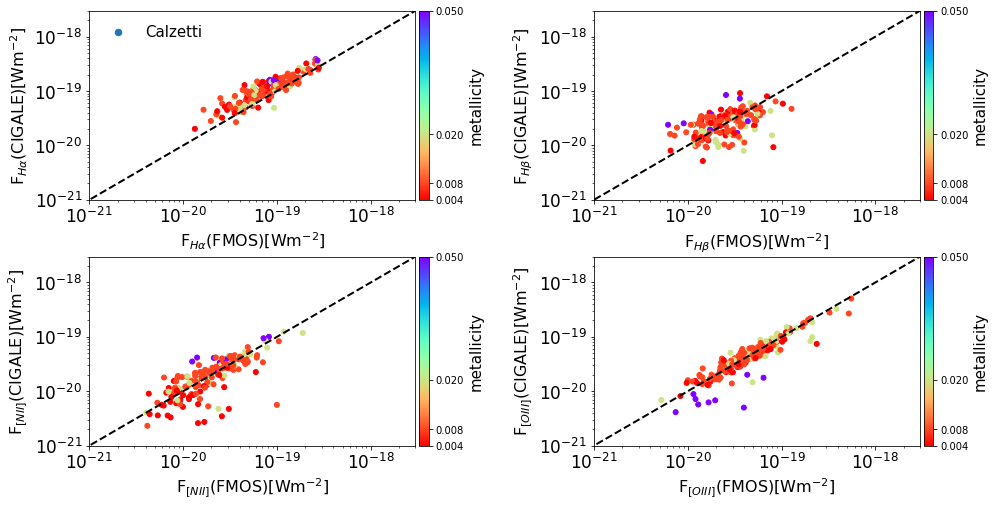

In [79]:
X_1 = np.linspace(0.0,9.0,100)

fig, ((axA, axB), (axC, axD)) = plt.subplots(figsize=(16,8), nrows=2, ncols=2)
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

axA.scatter(COSMOS['line.H-alpha'],\
            COSMOS_cigale_1['best.line.H-alpha'], marker = 'o', s = 30,\
            facecolor = 'none', edgecolors = 'C0', label = 'Calzetti')
axA.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axA.set_xlim(1e-21, 3e-18)
axA.set_ylim(1e-21, 3e-18)
axA.set_xscale('log')
axA.set_yscale('log')
axA.set_xlabel(r'F$_{H\alpha}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axA.set_ylabel(r'F$_{H\alpha}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axA.tick_params(axis = 'both', which = 'major', labelsize = 17)
axA.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'upper left')

axB.scatter(COSMOS['line.H-beta'],\
            COSMOS_cigale_1['best.line.H-beta'], marker = 'o', s = 30,\
            facecolor = 'none', edgecolors = 'C0')
axB.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axB.set_xlim(1e-21, 3e-18)
axB.set_ylim(1e-21, 3e-18)
axB.set_xscale('log')
axB.set_yscale('log')
axB.set_xlabel(r'F$_{H\beta}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axB.set_ylabel(r'F$_{H\beta}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axB.tick_params(axis = 'both', which = 'major', labelsize = 17)

axC.scatter(COSMOS['line.NII-658.4'],\
            COSMOS_cigale_1['best.line.NII-658.4'], marker = 'o', s = 30,\
            facecolor = 'none', edgecolors = 'C0')
axC.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axC.set_xlim(1e-21, 3e-18)
axC.set_ylim(1e-21, 3e-18)
axC.set_xscale('log')
axC.set_yscale('log')
axC.set_xlabel(r'F$_{[NII]}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axC.set_ylabel(r'F$_{[NII]}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axC.tick_params(axis = 'both', which = 'major', labelsize = 17)

axD.scatter(COSMOS['line.OIII-500.7'],\
            COSMOS_cigale_1['best.line.OIII-500.7'], marker = 'o', s = 30,\
            facecolor = 'none', edgecolors = 'C0')
axD.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axD.set_xlim(1e-21, 3e-18)
axD.set_ylim(1e-21, 3e-18)
axD.set_xscale('log')
axD.set_yscale('log')
axD.set_xlabel(r'F$_{[OIII]}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axD.set_ylabel(r'F$_{[OIII]}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axD.tick_params(axis = 'both', which = 'major', labelsize = 17)

# --------------------------------------------------------------------------------------------------------------------

X_1 = np.linspace(0.0,9.0,100)

fig, ((axA, axB), (axC, axD)) = plt.subplots(figsize=(16,8), nrows=2, ncols=2)
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

img1 = axA.scatter(COSMOS['line.H-alpha'], COSMOS_cigale_1['best.line.H-alpha'], \
                  s = 25, c = np.log10(COSMOS['line.H-alpha']/COSMOS['line.H-alpha_err']),\
                  cmap = plt.cm.rainbow_r, label = 'Calzetti')
ca = fig.colorbar(img1, ax=axA, pad = 0.01)
ca.set_label(label = r'log$_{10}$(SNR)', size = 15)
axA.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axA.set_xlim(1e-21, 3e-18)
axA.set_ylim(1e-21, 3e-18)
axA.set_xscale('log')
axA.set_yscale('log')
axA.set_xlabel(r'F$_{H\alpha}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axA.set_ylabel(r'F$_{H\alpha}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axA.tick_params(axis = 'both', which = 'major', labelsize = 17)
axA.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'upper left')

img2 = axB.scatter(COSMOS['line.H-beta'], COSMOS_cigale_1['best.line.H-beta'],\
                   s = 25, c = np.log10(COSMOS['line.H-beta']/COSMOS['line.H-beta_err']),\
                   cmap = plt.cm.rainbow_r)
cb = fig.colorbar(img2, ax=axB, pad = 0.01)
cb.set_label(label = r'log$_{10}$(SNR)', size = 15)
axB.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axB.set_xlim(1e-21, 3e-18)
axB.set_ylim(1e-21, 3e-18)
axB.set_xscale('log')
axB.set_yscale('log')
axB.set_xlabel(r'F$_{H\beta}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axB.set_ylabel(r'F$_{H\beta}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axB.tick_params(axis = 'both', which = 'major', labelsize = 17)

img3 = axC.scatter(COSMOS['line.NII-658.4'], COSMOS_cigale_1['best.line.NII-658.4'],\
                   s = 25, c = np.log10(COSMOS['line.NII-658.4']/COSMOS['line.NII-658.4_err']),\
                   cmap = plt.cm.rainbow_r)
cc = fig.colorbar(img3, ax=axC, pad = 0.01)
cc.set_label(label = r'log$_{10}$(SNR)', size = 15)
axC.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axC.set_xlim(1e-21, 3e-18)
axC.set_ylim(1e-21, 3e-18)
axC.set_xscale('log')
axC.set_yscale('log')
axC.set_xlabel(r'F$_{[NII]}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axC.set_ylabel(r'F$_{[NII]}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axC.tick_params(axis = 'both', which = 'major', labelsize = 17)

img4 = axD.scatter(COSMOS['line.OIII-500.7'], COSMOS_cigale_1['best.line.OIII-500.7'],\
                   s = 25, c = np.log10(COSMOS['line.OIII-500.7']/COSMOS['line.OIII-500.7_err']),\
                   cmap = plt.cm.rainbow_r)
cd = fig.colorbar(img4, ax=axD, pad = 0.01)
cd.set_label(label = r'log$_{10}$(SNR)', size = 15)
axD.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axD.set_xlim(1e-21, 3e-18)
axD.set_ylim(1e-21, 3e-18)
axD.set_xscale('log')
axD.set_yscale('log')
axD.set_xlabel(r'F$_{[OIII]}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axD.set_ylabel(r'F$_{[OIII]}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axD.tick_params(axis = 'both', which = 'major', labelsize = 17)

# --------------------------------------------------------------------------------------------------------------------

X_1 = np.linspace(0.0,9.0,100)

fig, ((axA, axB), (axC, axD)) = plt.subplots(figsize=(16,8), nrows=2, ncols=2)
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

img1 = axA.scatter(COSMOS['line.H-alpha'], COSMOS_cigale_1['best.line.H-alpha'], \
                  s = 25, c = COSMOS_cigale_1['best.nebular.logU'],\
                  cmap = plt.cm.rainbow_r, label = 'Calzetti')
ca = fig.colorbar(img1, ax=axA, ticks = [-3.4, -3.2, -3.0, -2.8, -2.6, -2.4, -2.2, -2.0, -1.8, -1.6, -1.4, -1.2, -1.0], pad = 0.01)
ca.set_label(label = 'logU', size = 15)
axA.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axA.set_xlim(1e-21, 3e-18)
axA.set_ylim(1e-21, 3e-18)
axA.set_xscale('log')
axA.set_yscale('log')
axA.set_xlabel(r'F$_{H\alpha}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axA.set_ylabel(r'F$_{H\alpha}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axA.tick_params(axis = 'both', which = 'major', labelsize = 17)
axA.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'upper left')

img2 = axB.scatter(COSMOS['line.H-beta'], COSMOS_cigale_1['best.line.H-beta'],\
                   s = 25, c = COSMOS_cigale_1['best.nebular.logU'],\
                   cmap = plt.cm.rainbow_r)
cb = fig.colorbar(img2, ax=axB, ticks = [-3.4, -3.2, -3.0, -2.8, -2.6, -2.4, -2.2, -2.0, -1.8, -1.6, -1.4, -1.2, -1.0], pad = 0.01)
cb.set_label(label = 'logU', size = 15)
axB.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axB.set_xlim(1e-21, 3e-18)
axB.set_ylim(1e-21, 3e-18)
axB.set_xscale('log')
axB.set_yscale('log')
axB.set_xlabel(r'F$_{H\beta}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axB.set_ylabel(r'F$_{H\beta}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axB.tick_params(axis = 'both', which = 'major', labelsize = 17)

img3 = axC.scatter(COSMOS['line.NII-658.4'], COSMOS_cigale_1['best.line.NII-658.4'],\
                   s = 25, c = COSMOS_cigale_1['best.nebular.logU'],\
                   cmap = plt.cm.rainbow_r)
cc = fig.colorbar(img3, ax=axC, ticks = [-3.4, -3.2, -3.0, -2.8, -2.6, -2.4, -2.2, -2.0, -1.8, -1.6, -1.4, -1.2, -1.0], pad = 0.01)
cc.set_label(label = 'logU', size = 15)
axC.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axC.set_xlim(1e-21, 3e-18)
axC.set_ylim(1e-21, 3e-18)
axC.set_xscale('log')
axC.set_yscale('log')
axC.set_xlabel(r'F$_{[NII]}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axC.set_ylabel(r'F$_{[NII]}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axC.tick_params(axis = 'both', which = 'major', labelsize = 17)

img4 = axD.scatter(COSMOS['line.OIII-500.7'], COSMOS_cigale_1['best.line.OIII-500.7'],\
                   s = 25, c = COSMOS_cigale_1['best.nebular.logU'],\
                   cmap = plt.cm.rainbow_r)
cd = fig.colorbar(img4, ax=axD, ticks = [-3.4, -3.2, -3.0, -2.8, -2.6, -2.4, -2.2, -2.0, -1.8, -1.6, -1.4, -1.2, -1.0], pad = 0.01)
cd.set_label(label = 'logU', size = 15)
axD.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axD.set_xlim(1e-21, 3e-18)
axD.set_ylim(1e-21, 3e-18)
axD.set_xscale('log')
axD.set_yscale('log')
axD.set_xlabel(r'F$_{[OIII]}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axD.set_ylabel(r'F$_{[OIII]}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axD.tick_params(axis = 'both', which = 'major', labelsize = 17)

# --------------------------------------------------------------------------------------------------------------------

X_1 = np.linspace(0.0,9.0,100)

fig, ((axA, axB), (axC, axD)) = plt.subplots(figsize=(16,8), nrows=2, ncols=2)
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

img1 = axA.scatter(COSMOS['line.H-alpha'], COSMOS_cigale_1['best.line.H-alpha'], \
                  s = 25, c = COSMOS_cigale_1['best.stellar.metallicity'],\
                  cmap = plt.cm.rainbow_r, label = 'Calzetti')
ca = fig.colorbar(img1, ax=axA, ticks = [0.004, 0.008, 0.02, 0.05], pad = 0.01)
ca.set_label(label = 'metallicity', size = 15)
axA.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axA.set_xlim(1e-21, 3e-18)
axA.set_ylim(1e-21, 3e-18)
axA.set_xscale('log')
axA.set_yscale('log')
axA.set_xlabel(r'F$_{H\alpha}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axA.set_ylabel(r'F$_{H\alpha}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axA.tick_params(axis = 'both', which = 'major', labelsize = 17)
axA.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'upper left')

img2 = axB.scatter(COSMOS['line.H-beta'], COSMOS_cigale_1['best.line.H-beta'],\
                   s = 25, c = COSMOS_cigale_1['best.stellar.metallicity'],\
                   cmap = plt.cm.rainbow_r)
cb = fig.colorbar(img2, ax=axB, ticks = [0.004, 0.008, 0.02, 0.05], pad = 0.01)
cb.set_label(label = 'metallicity', size = 15)
axB.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axB.set_xlim(1e-21, 3e-18)
axB.set_ylim(1e-21, 3e-18)
axB.set_xscale('log')
axB.set_yscale('log')
axB.set_xlabel(r'F$_{H\beta}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axB.set_ylabel(r'F$_{H\beta}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axB.tick_params(axis = 'both', which = 'major', labelsize = 17)

img3 = axC.scatter(COSMOS['line.NII-658.4'], COSMOS_cigale_1['best.line.NII-658.4'],\
                   s = 25, c = COSMOS_cigale_1['best.stellar.metallicity'],\
                   cmap = plt.cm.rainbow_r)
cc = fig.colorbar(img3, ax=axC, ticks = [0.004, 0.008, 0.02, 0.05], pad = 0.01)
cc.set_label(label = 'metallicity', size = 15)
axC.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axC.set_xlim(1e-21, 3e-18)
axC.set_ylim(1e-21, 3e-18)
axC.set_xscale('log')
axC.set_yscale('log')
axC.set_xlabel(r'F$_{[NII]}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axC.set_ylabel(r'F$_{[NII]}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axC.tick_params(axis = 'both', which = 'major', labelsize = 17)

img4 = axD.scatter(COSMOS['line.OIII-500.7'], COSMOS_cigale_1['best.line.OIII-500.7'],\
                   s = 25, c = COSMOS_cigale_1['best.stellar.metallicity'],\
                   cmap = plt.cm.rainbow_r)
cd = fig.colorbar(img4, ax=axD, ticks = [0.004, 0.008, 0.02, 0.05], pad = 0.01)
cd.set_label(label = 'metallicity', size = 15)
axD.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axD.set_xlim(1e-21, 3e-18)
axD.set_ylim(1e-21, 3e-18)
axD.set_xscale('log')
axD.set_yscale('log')
axD.set_xlabel(r'F$_{[OIII]}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axD.set_ylabel(r'F$_{[OIII]}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axD.tick_params(axis = 'both', which = 'major', labelsize = 17)

In [80]:
# plt.figure(figsize = (8,5.5))
# plt.hist(COSMOS_cigale_1['bayes.line.H-alpha'], histtype = 'step')
# plt.hist(COSMOS_cigale_1['best.line.H-alpha'], histtype = 'step')
# plt.hist(COSMOS_cigale_1['bayes.line.H-beta'], histtype = 'step')
# plt.hist(COSMOS_cigale_1['best.line.H-beta'], histtype = 'step')
# plt.hist(COSMOS_cigale_1['bayes.line.NII-658.4'], histtype = 'step')
# plt.hist(COSMOS_cigale_1['best.line.NII-658.4'], histtype = 'step')
# plt.hist(COSMOS_cigale_1['bayes.line.OIII-500.7'], histtype = 'step')
# plt.hist(COSMOS_cigale_1['best.line.OIII-500.7'], histtype = 'step')
# plt.yscale('symlog')
# plt.xlabel(r'flux [W/m$^2$]', fontsize = 15)
# plt.ylabel('Number of galaxies', fontsize = 15)
# plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
# plt.legend(frameon = False, prop = {'size': 15}, markerscale = 1.5 , loc = 'upper right');

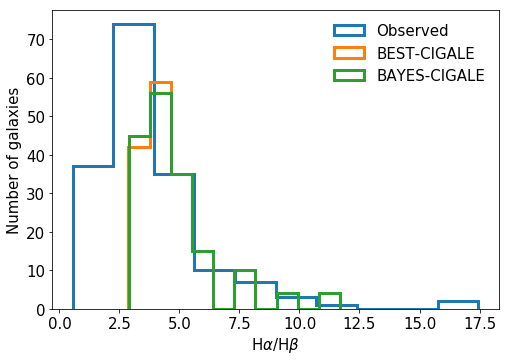

In [6]:
plt.figure(figsize = (8,5.5))
plt.hist(COSMOS['line.H-alpha']/COSMOS['line.H-beta'], histtype = 'step', lw = 3, label = 'Observed')
plt.hist(COSMOS_cigale_1['best.line.H-alpha']/COSMOS_cigale_1['best.line.H-beta'], histtype = 'step', lw = 3, label = 'BEST-CIGALE')
plt.hist(COSMOS_cigale_1['bayes.line.H-alpha']/COSMOS_cigale_1['bayes.line.H-beta'], histtype = 'step', lw = 3, label = 'BAYES-CIGALE')
plt.xlabel(r'H$\alpha$/H$\beta$', fontsize = 15)
plt.ylabel('Number of galaxies', fontsize = 15)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.legend(frameon = False, prop = {'size': 15}, markerscale = 1.5 , loc = 'upper right');

In [7]:
bad_data            = COSMOS[COSMOS['line.H-alpha']/COSMOS['line.H-beta'] < 2.85]
COSMOS_cigale_bad_1 = COSMOS_cigale_1[np.where(COSMOS['line.H-alpha']/COSMOS['line.H-beta'] < 2.85)]
COSMOS_cigale_bad_2 = COSMOS_cigale_2[np.where(COSMOS['line.H-alpha']/COSMOS['line.H-beta'] < 2.85)]
COSMOS_cigale_bad_3 = COSMOS_cigale_3[np.where(COSMOS['line.H-alpha']/COSMOS['line.H-beta'] < 2.85)]

good_data            = COSMOS[COSMOS['line.H-alpha']/COSMOS['line.H-beta'] > 2.85]
COSMOS_cigale_good_1 = COSMOS_cigale_1[np.where(COSMOS['line.H-alpha']/COSMOS['line.H-beta'] > 2.85)]
COSMOS_cigale_good_2 = COSMOS_cigale_2[np.where(COSMOS['line.H-alpha']/COSMOS['line.H-beta'] > 2.85)]
COSMOS_cigale_good_3 = COSMOS_cigale_3[np.where(COSMOS['line.H-alpha']/COSMOS['line.H-beta'] > 2.85)]

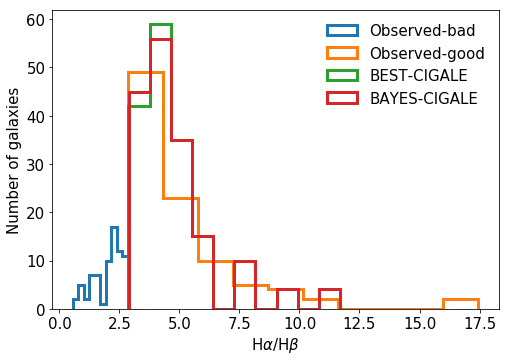

In [8]:
plt.figure(figsize = (8,5.5))
plt.hist(bad_data['line.H-alpha']/bad_data['line.H-beta'], histtype = 'step', lw = 3, label = 'Observed-bad')
plt.hist(good_data['line.H-alpha']/good_data['line.H-beta'], histtype = 'step', lw = 3, label = 'Observed-good')
plt.hist(COSMOS_cigale_1['best.line.H-alpha']/COSMOS_cigale_1['best.line.H-beta'], histtype = 'step', lw = 3, label = 'BEST-CIGALE')
plt.hist(COSMOS_cigale_1['bayes.line.H-alpha']/COSMOS_cigale_1['bayes.line.H-beta'], histtype = 'step', lw = 3, label = 'BAYES-CIGALE')
plt.xlabel(r'H$\alpha$/H$\beta$', fontsize = 15)
plt.ylabel('Number of galaxies', fontsize = 15)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.legend(frameon = False, prop = {'size': 15}, markerscale = 1.5 , loc = 'upper right');

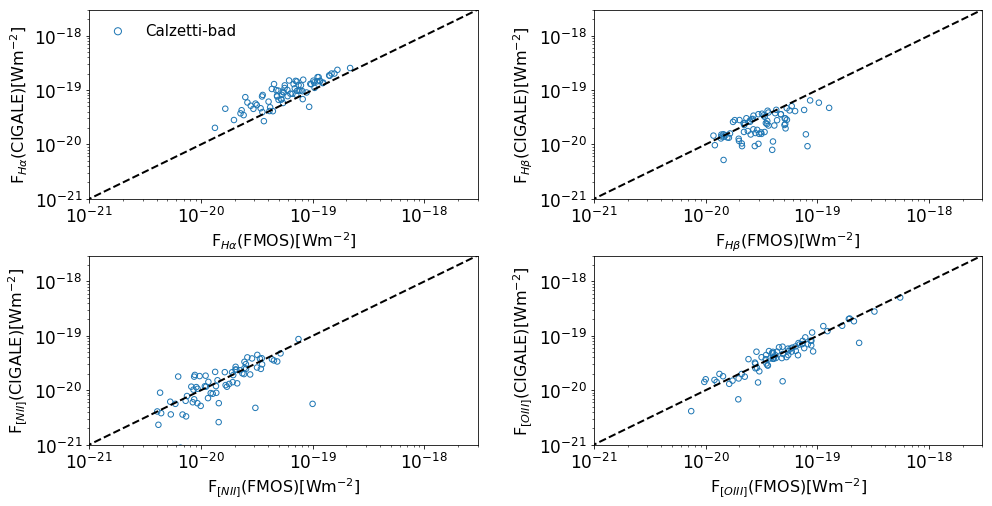

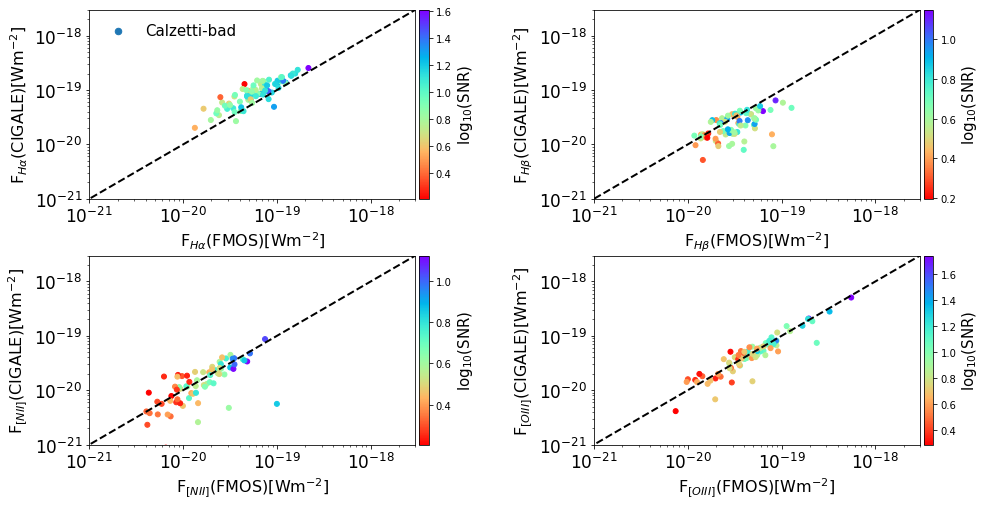

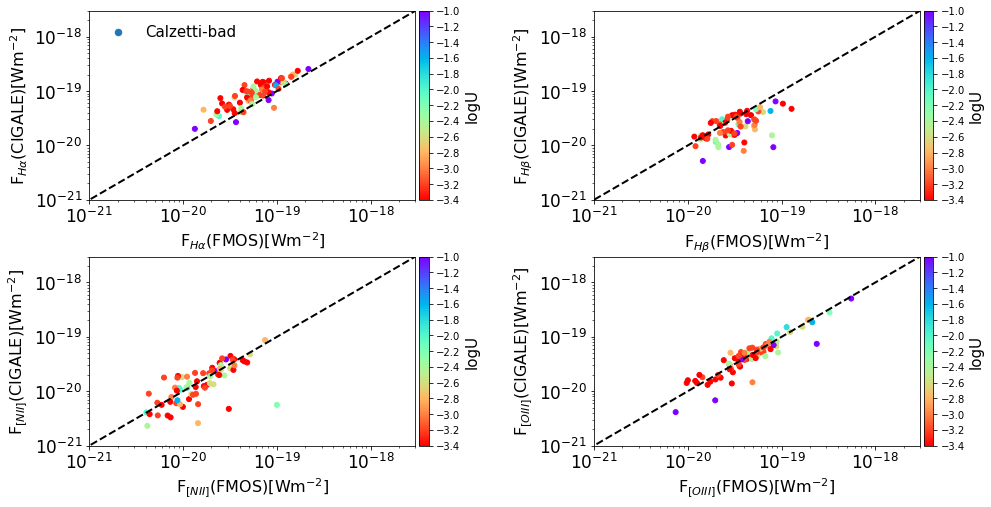

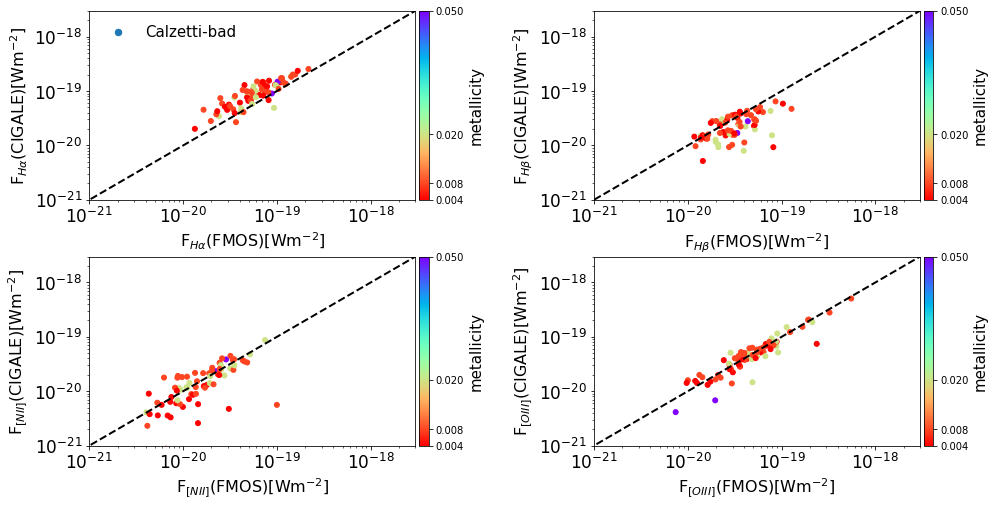

In [84]:
X_1 = np.linspace(0.0,9.0,100)

fig, ((axA, axB), (axC, axD)) = plt.subplots(figsize=(16,8), nrows=2, ncols=2)
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

axA.scatter(bad_data['line.H-alpha'],\
            COSMOS_cigale_bad_1['best.line.H-alpha'], marker = 'o', s = 30,\
            facecolor = 'none', edgecolors = 'C0', label = 'Calzetti-bad')
axA.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axA.set_xlim(1e-21, 3e-18)
axA.set_ylim(1e-21, 3e-18)
axA.set_xscale('log')
axA.set_yscale('log')
axA.set_xlabel(r'F$_{H\alpha}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axA.set_ylabel(r'F$_{H\alpha}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axA.tick_params(axis = 'both', which = 'major', labelsize = 17)
axA.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'upper left')

axB.scatter(bad_data['line.H-beta'],\
            COSMOS_cigale_bad_1['best.line.H-beta'], marker = 'o', s = 30,\
            facecolor = 'none', edgecolors = 'C0')
axB.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axB.set_xlim(1e-21, 3e-18)
axB.set_ylim(1e-21, 3e-18)
axB.set_xscale('log')
axB.set_yscale('log')
axB.set_xlabel(r'F$_{H\beta}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axB.set_ylabel(r'F$_{H\beta}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axB.tick_params(axis = 'both', which = 'major', labelsize = 17)

axC.scatter(bad_data['line.NII-658.4'],\
            COSMOS_cigale_bad_1['best.line.NII-658.4'], marker = 'o', s = 30,\
            facecolor = 'none', edgecolors = 'C0')
axC.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axC.set_xlim(1e-21, 3e-18)
axC.set_ylim(1e-21, 3e-18)
axC.set_xscale('log')
axC.set_yscale('log')
axC.set_xlabel(r'F$_{[NII]}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axC.set_ylabel(r'F$_{[NII]}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axC.tick_params(axis = 'both', which = 'major', labelsize = 17)

axD.scatter(bad_data['line.OIII-500.7'],\
            COSMOS_cigale_bad_1['best.line.OIII-500.7'], marker = 'o', s = 30,\
            facecolor = 'none', edgecolors = 'C0')
axD.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axD.set_xlim(1e-21, 3e-18)
axD.set_ylim(1e-21, 3e-18)
axD.set_xscale('log')
axD.set_yscale('log')
axD.set_xlabel(r'F$_{[OIII]}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axD.set_ylabel(r'F$_{[OIII]}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axD.tick_params(axis = 'both', which = 'major', labelsize = 17)

# --------------------------------------------------------------------------------------------------------------------

X_1 = np.linspace(0.0,9.0,100)

fig, ((axA, axB), (axC, axD)) = plt.subplots(figsize=(16,8), nrows=2, ncols=2)
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

img1 = axA.scatter(bad_data['line.H-alpha'], COSMOS_cigale_bad_1['best.line.H-alpha'], \
                  s = 25, c = np.log10(bad_data['line.H-alpha']/bad_data['line.H-alpha_err']),\
                  cmap = plt.cm.rainbow_r, label = 'Calzetti-bad')
ca = fig.colorbar(img1, ax=axA, pad = 0.01)
ca.set_label(label = r'log$_{10}$(SNR)', size = 15)
axA.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axA.set_xlim(1e-21, 3e-18)
axA.set_ylim(1e-21, 3e-18)
axA.set_xscale('log')
axA.set_yscale('log')
axA.set_xlabel(r'F$_{H\alpha}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axA.set_ylabel(r'F$_{H\alpha}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axA.tick_params(axis = 'both', which = 'major', labelsize = 17)
axA.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'upper left')

img2 = axB.scatter(bad_data['line.H-beta'], COSMOS_cigale_bad_1['best.line.H-beta'],\
                   s = 25, c = np.log10(bad_data['line.H-beta']/bad_data['line.H-beta_err']),\
                   cmap = plt.cm.rainbow_r)
cb = fig.colorbar(img2, ax=axB, pad = 0.01)
cb.set_label(label = r'log$_{10}$(SNR)', size = 15)
axB.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axB.set_xlim(1e-21, 3e-18)
axB.set_ylim(1e-21, 3e-18)
axB.set_xscale('log')
axB.set_yscale('log')
axB.set_xlabel(r'F$_{H\beta}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axB.set_ylabel(r'F$_{H\beta}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axB.tick_params(axis = 'both', which = 'major', labelsize = 17)

img3 = axC.scatter(bad_data['line.NII-658.4'], COSMOS_cigale_bad_1['best.line.NII-658.4'],\
                   s = 25, c = np.log10(bad_data['line.NII-658.4']/bad_data['line.NII-658.4_err']),\
                   cmap = plt.cm.rainbow_r)
cc = fig.colorbar(img3, ax=axC, pad = 0.01)
cc.set_label(label = r'log$_{10}$(SNR)', size = 15)
axC.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axC.set_xlim(1e-21, 3e-18)
axC.set_ylim(1e-21, 3e-18)
axC.set_xscale('log')
axC.set_yscale('log')
axC.set_xlabel(r'F$_{[NII]}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axC.set_ylabel(r'F$_{[NII]}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axC.tick_params(axis = 'both', which = 'major', labelsize = 17)

img4 = axD.scatter(bad_data['line.OIII-500.7'], COSMOS_cigale_bad_1['best.line.OIII-500.7'],\
                   s = 25, c = np.log10(bad_data['line.OIII-500.7']/bad_data['line.OIII-500.7_err']),\
                   cmap = plt.cm.rainbow_r)
cd = fig.colorbar(img4, ax=axD, pad = 0.01)
cd.set_label(label = r'log$_{10}$(SNR)', size = 15)
axD.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axD.set_xlim(1e-21, 3e-18)
axD.set_ylim(1e-21, 3e-18)
axD.set_xscale('log')
axD.set_yscale('log')
axD.set_xlabel(r'F$_{[OIII]}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axD.set_ylabel(r'F$_{[OIII]}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axD.tick_params(axis = 'both', which = 'major', labelsize = 17)

# --------------------------------------------------------------------------------------------------------------------

X_1 = np.linspace(0.0,9.0,100)

fig, ((axA, axB), (axC, axD)) = plt.subplots(figsize=(16,8), nrows=2, ncols=2)
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

img1 = axA.scatter(bad_data['line.H-alpha'], COSMOS_cigale_bad_1['best.line.H-alpha'], \
                  s = 25, c = COSMOS_cigale_bad_1['best.nebular.logU'],\
                  cmap = plt.cm.rainbow_r, label = 'Calzetti-bad')
ca = fig.colorbar(img1, ax=axA, ticks = [-3.4, -3.2, -3.0, -2.8, -2.6, -2.4, -2.2, -2.0, -1.8, -1.6, -1.4, -1.2, -1.0], pad = 0.01)
ca.set_label(label = 'logU', size = 15)
axA.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axA.set_xlim(1e-21, 3e-18)
axA.set_ylim(1e-21, 3e-18)
axA.set_xscale('log')
axA.set_yscale('log')
axA.set_xlabel(r'F$_{H\alpha}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axA.set_ylabel(r'F$_{H\alpha}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axA.tick_params(axis = 'both', which = 'major', labelsize = 17)
axA.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'upper left')

img2 = axB.scatter(bad_data['line.H-beta'], COSMOS_cigale_bad_1['best.line.H-beta'],\
                   s = 25, c = COSMOS_cigale_bad_1['best.nebular.logU'],\
                   cmap = plt.cm.rainbow_r)
cb = fig.colorbar(img2, ax=axB, ticks = [-3.4, -3.2, -3.0, -2.8, -2.6, -2.4, -2.2, -2.0, -1.8, -1.6, -1.4, -1.2, -1.0], pad = 0.01)
cb.set_label(label = 'logU', size = 15)
axB.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axB.set_xlim(1e-21, 3e-18)
axB.set_ylim(1e-21, 3e-18)
axB.set_xscale('log')
axB.set_yscale('log')
axB.set_xlabel(r'F$_{H\beta}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axB.set_ylabel(r'F$_{H\beta}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axB.tick_params(axis = 'both', which = 'major', labelsize = 17)

img3 = axC.scatter(bad_data['line.NII-658.4'], COSMOS_cigale_bad_1['best.line.NII-658.4'],\
                   s = 25, c = COSMOS_cigale_bad_1['best.nebular.logU'],\
                   cmap = plt.cm.rainbow_r)
cc = fig.colorbar(img3, ax=axC, ticks = [-3.4, -3.2, -3.0, -2.8, -2.6, -2.4, -2.2, -2.0, -1.8, -1.6, -1.4, -1.2, -1.0], pad = 0.01)
cc.set_label(label = 'logU', size = 15)
axC.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axC.set_xlim(1e-21, 3e-18)
axC.set_ylim(1e-21, 3e-18)
axC.set_xscale('log')
axC.set_yscale('log')
axC.set_xlabel(r'F$_{[NII]}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axC.set_ylabel(r'F$_{[NII]}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axC.tick_params(axis = 'both', which = 'major', labelsize = 17)

img4 = axD.scatter(bad_data['line.OIII-500.7'], COSMOS_cigale_bad_1['best.line.OIII-500.7'],\
                   s = 25, c = COSMOS_cigale_bad_1['best.nebular.logU'],\
                   cmap = plt.cm.rainbow_r)
cd = fig.colorbar(img4, ax=axD, ticks = [-3.4, -3.2, -3.0, -2.8, -2.6, -2.4, -2.2, -2.0, -1.8, -1.6, -1.4, -1.2, -1.0], pad = 0.01)
cd.set_label(label = 'logU', size = 15)
axD.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axD.set_xlim(1e-21, 3e-18)
axD.set_ylim(1e-21, 3e-18)
axD.set_xscale('log')
axD.set_yscale('log')
axD.set_xlabel(r'F$_{[OIII]}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axD.set_ylabel(r'F$_{[OIII]}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axD.tick_params(axis = 'both', which = 'major', labelsize = 17)

# --------------------------------------------------------------------------------------------------------------------

X_1 = np.linspace(0.0,9.0,100)

fig, ((axA, axB), (axC, axD)) = plt.subplots(figsize=(16,8), nrows=2, ncols=2)
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

img1 = axA.scatter(bad_data['line.H-alpha'], COSMOS_cigale_bad_1['best.line.H-alpha'], \
                  s = 25, c = COSMOS_cigale_bad_1['best.stellar.metallicity'],\
                  cmap = plt.cm.rainbow_r, label = 'Calzetti-bad')
ca = fig.colorbar(img1, ax=axA, ticks = [0.004, 0.008, 0.02, 0.05], pad = 0.01)
ca.set_label(label = 'metallicity', size = 15)
axA.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axA.set_xlim(1e-21, 3e-18)
axA.set_ylim(1e-21, 3e-18)
axA.set_xscale('log')
axA.set_yscale('log')
axA.set_xlabel(r'F$_{H\alpha}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axA.set_ylabel(r'F$_{H\alpha}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axA.tick_params(axis = 'both', which = 'major', labelsize = 17)
axA.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'upper left')

img2 = axB.scatter(bad_data['line.H-beta'], COSMOS_cigale_bad_1['best.line.H-beta'],\
                   s = 25, c = COSMOS_cigale_bad_1['best.stellar.metallicity'],\
                   cmap = plt.cm.rainbow_r)
cb = fig.colorbar(img2, ax=axB, ticks = [0.004, 0.008, 0.02, 0.05], pad = 0.01)
cb.set_label(label = 'metallicity', size = 15)
axB.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axB.set_xlim(1e-21, 3e-18)
axB.set_ylim(1e-21, 3e-18)
axB.set_xscale('log')
axB.set_yscale('log')
axB.set_xlabel(r'F$_{H\beta}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axB.set_ylabel(r'F$_{H\beta}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axB.tick_params(axis = 'both', which = 'major', labelsize = 17)

img3 = axC.scatter(bad_data['line.NII-658.4'], COSMOS_cigale_bad_1['best.line.NII-658.4'],\
                   s = 25, c = COSMOS_cigale_bad_1['best.stellar.metallicity'],\
                   cmap = plt.cm.rainbow_r)
cc = fig.colorbar(img3, ax=axC, ticks = [0.004, 0.008, 0.02, 0.05], pad = 0.01)
cc.set_label(label = 'metallicity', size = 15)
axC.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axC.set_xlim(1e-21, 3e-18)
axC.set_ylim(1e-21, 3e-18)
axC.set_xscale('log')
axC.set_yscale('log')
axC.set_xlabel(r'F$_{[NII]}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axC.set_ylabel(r'F$_{[NII]}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axC.tick_params(axis = 'both', which = 'major', labelsize = 17)

img4 = axD.scatter(bad_data['line.OIII-500.7'], COSMOS_cigale_bad_1['best.line.OIII-500.7'],\
                   s = 25, c = COSMOS_cigale_bad_1['best.stellar.metallicity'],\
                   cmap = plt.cm.rainbow_r)
cd = fig.colorbar(img4, ax=axD, ticks = [0.004, 0.008, 0.02, 0.05], pad = 0.01)
cd.set_label(label = 'metallicity', size = 15)
axD.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axD.set_xlim(1e-21, 3e-18)
axD.set_ylim(1e-21, 3e-18)
axD.set_xscale('log')
axD.set_yscale('log')
axD.set_xlabel(r'F$_{[OIII]}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axD.set_ylabel(r'F$_{[OIII]}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axD.tick_params(axis = 'both', which = 'major', labelsize = 17)

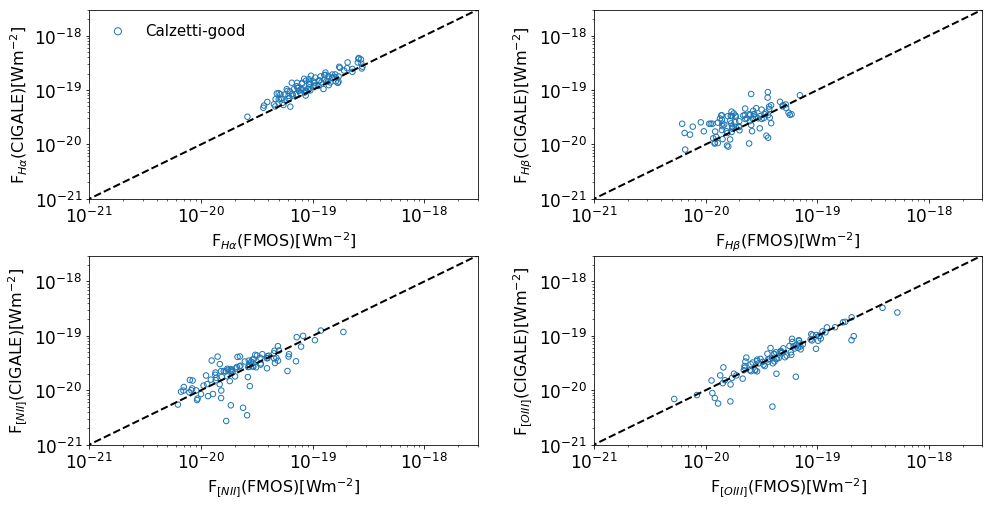

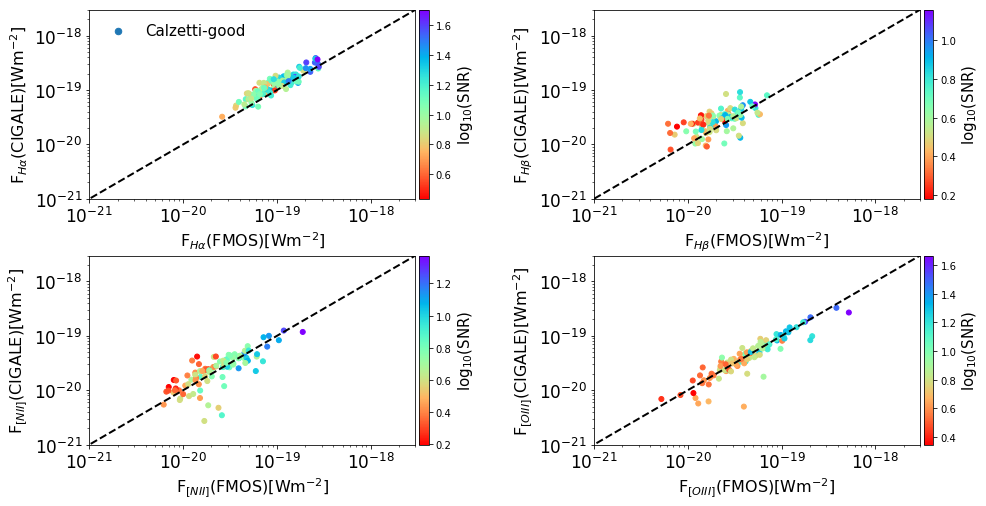

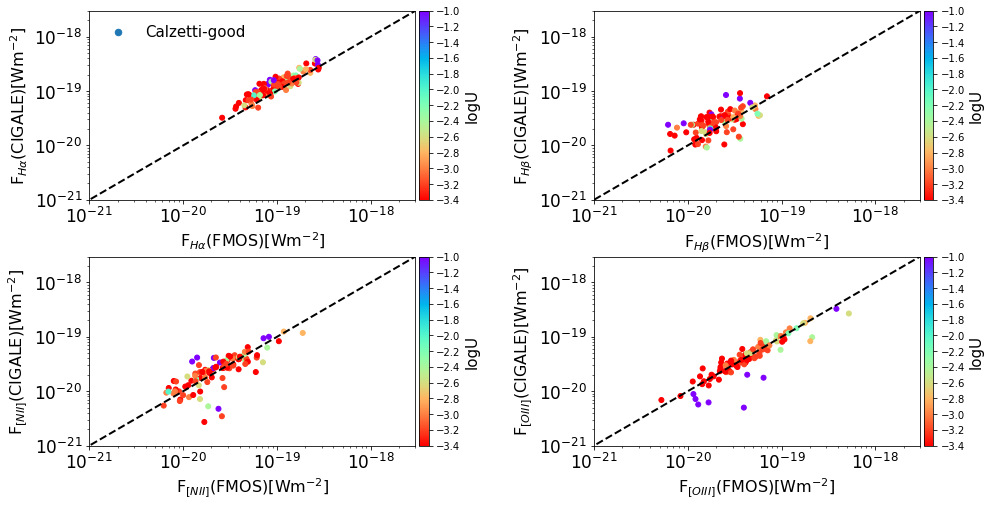

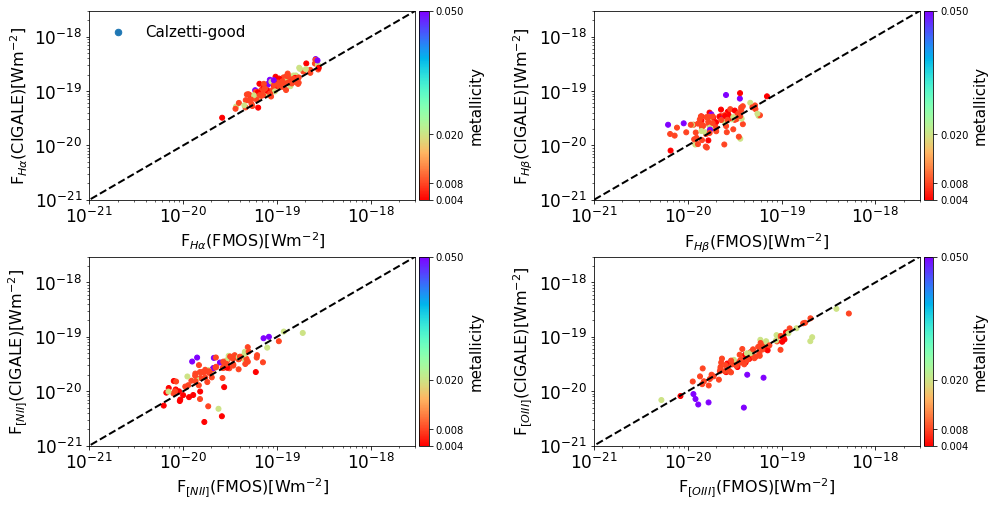

In [85]:
X_1 = np.linspace(0.0,9.0,100)

fig, ((axA, axB), (axC, axD)) = plt.subplots(figsize=(16,8), nrows=2, ncols=2)
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

axA.scatter(good_data['line.H-alpha'],\
            COSMOS_cigale_good_1['best.line.H-alpha'], marker = 'o', s = 30,\
            facecolor = 'none', edgecolors = 'C0', label = 'Calzetti-good')
axA.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axA.set_xlim(1e-21, 3e-18)
axA.set_ylim(1e-21, 3e-18)
axA.set_xscale('log')
axA.set_yscale('log')
axA.set_xlabel(r'F$_{H\alpha}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axA.set_ylabel(r'F$_{H\alpha}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axA.tick_params(axis = 'both', which = 'major', labelsize = 17)
axA.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'upper left')

axB.scatter(good_data['line.H-beta'],\
            COSMOS_cigale_good_1['best.line.H-beta'], marker = 'o', s = 30,\
            facecolor = 'none', edgecolors = 'C0')
axB.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axB.set_xlim(1e-21, 3e-18)
axB.set_ylim(1e-21, 3e-18)
axB.set_xscale('log')
axB.set_yscale('log')
axB.set_xlabel(r'F$_{H\beta}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axB.set_ylabel(r'F$_{H\beta}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axB.tick_params(axis = 'both', which = 'major', labelsize = 17)

axC.scatter(good_data['line.NII-658.4'],\
            COSMOS_cigale_good_1['best.line.NII-658.4'], marker = 'o', s = 30,\
            facecolor = 'none', edgecolors = 'C0')
axC.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axC.set_xlim(1e-21, 3e-18)
axC.set_ylim(1e-21, 3e-18)
axC.set_xscale('log')
axC.set_yscale('log')
axC.set_xlabel(r'F$_{[NII]}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axC.set_ylabel(r'F$_{[NII]}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axC.tick_params(axis = 'both', which = 'major', labelsize = 17)

axD.scatter(good_data['line.OIII-500.7'],\
            COSMOS_cigale_good_1['best.line.OIII-500.7'], marker = 'o', s = 30,\
            facecolor = 'none', edgecolors = 'C0')
axD.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axD.set_xlim(1e-21, 3e-18)
axD.set_ylim(1e-21, 3e-18)
axD.set_xscale('log')
axD.set_yscale('log')
axD.set_xlabel(r'F$_{[OIII]}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axD.set_ylabel(r'F$_{[OIII]}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axD.tick_params(axis = 'both', which = 'major', labelsize = 17)

# --------------------------------------------------------------------------------------------------------------------

X_1 = np.linspace(0.0,9.0,100)

fig, ((axA, axB), (axC, axD)) = plt.subplots(figsize=(16,8), nrows=2, ncols=2)
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

img1 = axA.scatter(good_data['line.H-alpha'], COSMOS_cigale_good_1['best.line.H-alpha'], \
                  s = 25, c = np.log10(good_data['line.H-alpha']/good_data['line.H-alpha_err']),\
                  cmap = plt.cm.rainbow_r, label = 'Calzetti-good')
ca = fig.colorbar(img1, ax=axA, pad = 0.01)
ca.set_label(label = r'log$_{10}$(SNR)', size = 15)
axA.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axA.set_xlim(1e-21, 3e-18)
axA.set_ylim(1e-21, 3e-18)
axA.set_xscale('log')
axA.set_yscale('log')
axA.set_xlabel(r'F$_{H\alpha}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axA.set_ylabel(r'F$_{H\alpha}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axA.tick_params(axis = 'both', which = 'major', labelsize = 17)
axA.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'upper left')

img2 = axB.scatter(good_data['line.H-beta'], COSMOS_cigale_good_1['best.line.H-beta'],\
                   s = 25, c = np.log10(good_data['line.H-beta']/good_data['line.H-beta_err']),\
                   cmap = plt.cm.rainbow_r)
cb = fig.colorbar(img2, ax=axB, pad = 0.01)
cb.set_label(label = r'log$_{10}$(SNR)', size = 15)
axB.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axB.set_xlim(1e-21, 3e-18)
axB.set_ylim(1e-21, 3e-18)
axB.set_xscale('log')
axB.set_yscale('log')
axB.set_xlabel(r'F$_{H\beta}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axB.set_ylabel(r'F$_{H\beta}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axB.tick_params(axis = 'both', which = 'major', labelsize = 17)

img3 = axC.scatter(good_data['line.NII-658.4'], COSMOS_cigale_good_1['best.line.NII-658.4'],\
                   s = 25, c = np.log10(good_data['line.NII-658.4']/good_data['line.NII-658.4_err']),\
                   cmap = plt.cm.rainbow_r)
cc = fig.colorbar(img3, ax=axC, pad = 0.01)
cc.set_label(label = r'log$_{10}$(SNR)', size = 15)
axC.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axC.set_xlim(1e-21, 3e-18)
axC.set_ylim(1e-21, 3e-18)
axC.set_xscale('log')
axC.set_yscale('log')
axC.set_xlabel(r'F$_{[NII]}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axC.set_ylabel(r'F$_{[NII]}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axC.tick_params(axis = 'both', which = 'major', labelsize = 17)

img4 = axD.scatter(good_data['line.OIII-500.7'], COSMOS_cigale_good_1['best.line.OIII-500.7'],\
                   s = 25, c = np.log10(good_data['line.OIII-500.7']/good_data['line.OIII-500.7_err']),\
                   cmap = plt.cm.rainbow_r)
cd = fig.colorbar(img4, ax=axD, pad = 0.01)
cd.set_label(label = r'log$_{10}$(SNR)', size = 15)
axD.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axD.set_xlim(1e-21, 3e-18)
axD.set_ylim(1e-21, 3e-18)
axD.set_xscale('log')
axD.set_yscale('log')
axD.set_xlabel(r'F$_{[OIII]}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axD.set_ylabel(r'F$_{[OIII]}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axD.tick_params(axis = 'both', which = 'major', labelsize = 17)

# --------------------------------------------------------------------------------------------------------------------

X_1 = np.linspace(0.0,9.0,100)

fig, ((axA, axB), (axC, axD)) = plt.subplots(figsize=(16,8), nrows=2, ncols=2)
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

img1 = axA.scatter(good_data['line.H-alpha'], COSMOS_cigale_good_1['best.line.H-alpha'], \
                  s = 25, c = COSMOS_cigale_good_1['best.nebular.logU'],\
                  cmap = plt.cm.rainbow_r, label = 'Calzetti-good')
ca = fig.colorbar(img1, ax=axA, ticks = [-3.4, -3.2, -3.0, -2.8, -2.6, -2.4, -2.2, -2.0, -1.8, -1.6, -1.4, -1.2, -1.0], pad = 0.01)
ca.set_label(label = 'logU', size = 15)
axA.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axA.set_xlim(1e-21, 3e-18)
axA.set_ylim(1e-21, 3e-18)
axA.set_xscale('log')
axA.set_yscale('log')
axA.set_xlabel(r'F$_{H\alpha}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axA.set_ylabel(r'F$_{H\alpha}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axA.tick_params(axis = 'both', which = 'major', labelsize = 17)
axA.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'upper left')

img2 = axB.scatter(good_data['line.H-beta'], COSMOS_cigale_good_1['best.line.H-beta'],\
                   s = 25, c = COSMOS_cigale_good_1['best.nebular.logU'],\
                   cmap = plt.cm.rainbow_r)
cb = fig.colorbar(img2, ax=axB, ticks = [-3.4, -3.2, -3.0, -2.8, -2.6, -2.4, -2.2, -2.0, -1.8, -1.6, -1.4, -1.2, -1.0], pad = 0.01)
cb.set_label(label = 'logU', size = 15)
axB.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axB.set_xlim(1e-21, 3e-18)
axB.set_ylim(1e-21, 3e-18)
axB.set_xscale('log')
axB.set_yscale('log')
axB.set_xlabel(r'F$_{H\beta}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axB.set_ylabel(r'F$_{H\beta}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axB.tick_params(axis = 'both', which = 'major', labelsize = 17)

img3 = axC.scatter(good_data['line.NII-658.4'], COSMOS_cigale_good_1['best.line.NII-658.4'],\
                   s = 25, c = COSMOS_cigale_good_1['best.nebular.logU'],\
                   cmap = plt.cm.rainbow_r)
cc = fig.colorbar(img3, ax=axC, ticks = [-3.4, -3.2, -3.0, -2.8, -2.6, -2.4, -2.2, -2.0, -1.8, -1.6, -1.4, -1.2, -1.0], pad = 0.01)
cc.set_label(label = 'logU', size = 15)
axC.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axC.set_xlim(1e-21, 3e-18)
axC.set_ylim(1e-21, 3e-18)
axC.set_xscale('log')
axC.set_yscale('log')
axC.set_xlabel(r'F$_{[NII]}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axC.set_ylabel(r'F$_{[NII]}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axC.tick_params(axis = 'both', which = 'major', labelsize = 17)

img4 = axD.scatter(good_data['line.OIII-500.7'], COSMOS_cigale_good_1['best.line.OIII-500.7'],\
                   s = 25, c = COSMOS_cigale_good_1['best.nebular.logU'],\
                   cmap = plt.cm.rainbow_r)
cd = fig.colorbar(img4, ax=axD, ticks = [-3.4, -3.2, -3.0, -2.8, -2.6, -2.4, -2.2, -2.0, -1.8, -1.6, -1.4, -1.2, -1.0], pad = 0.01)
cd.set_label(label = 'logU', size = 15)
axD.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axD.set_xlim(1e-21, 3e-18)
axD.set_ylim(1e-21, 3e-18)
axD.set_xscale('log')
axD.set_yscale('log')
axD.set_xlabel(r'F$_{[OIII]}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axD.set_ylabel(r'F$_{[OIII]}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axD.tick_params(axis = 'both', which = 'major', labelsize = 17)

# --------------------------------------------------------------------------------------------------------------------

X_1 = np.linspace(0.0,9.0,100)

fig, ((axA, axB), (axC, axD)) = plt.subplots(figsize=(16,8), nrows=2, ncols=2)
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

img1 = axA.scatter(good_data['line.H-alpha'], COSMOS_cigale_good_1['best.line.H-alpha'], \
                  s = 25, c = COSMOS_cigale_good_1['best.stellar.metallicity'],\
                  cmap = plt.cm.rainbow_r, label = 'Calzetti-good')
ca = fig.colorbar(img1, ax=axA, ticks = [0.004, 0.008, 0.02, 0.05], pad = 0.01)
ca.set_label(label = 'metallicity', size = 15)
axA.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axA.set_xlim(1e-21, 3e-18)
axA.set_ylim(1e-21, 3e-18)
axA.set_xscale('log')
axA.set_yscale('log')
axA.set_xlabel(r'F$_{H\alpha}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axA.set_ylabel(r'F$_{H\alpha}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axA.tick_params(axis = 'both', which = 'major', labelsize = 17)
axA.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'upper left')

img2 = axB.scatter(good_data['line.H-beta'], COSMOS_cigale_good_1['best.line.H-beta'],\
                   s = 25, c = COSMOS_cigale_good_1['best.stellar.metallicity'],\
                   cmap = plt.cm.rainbow_r)
cb = fig.colorbar(img2, ax=axB, ticks = [0.004, 0.008, 0.02, 0.05], pad = 0.01)
cb.set_label(label = 'metallicity', size = 15)
axB.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axB.set_xlim(1e-21, 3e-18)
axB.set_ylim(1e-21, 3e-18)
axB.set_xscale('log')
axB.set_yscale('log')
axB.set_xlabel(r'F$_{H\beta}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axB.set_ylabel(r'F$_{H\beta}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axB.tick_params(axis = 'both', which = 'major', labelsize = 17)

img3 = axC.scatter(good_data['line.NII-658.4'], COSMOS_cigale_good_1['best.line.NII-658.4'],\
                   s = 25, c = COSMOS_cigale_good_1['best.stellar.metallicity'],\
                   cmap = plt.cm.rainbow_r)
cc = fig.colorbar(img3, ax=axC, ticks = [0.004, 0.008, 0.02, 0.05], pad = 0.01)
cc.set_label(label = 'metallicity', size = 15)
axC.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axC.set_xlim(1e-21, 3e-18)
axC.set_ylim(1e-21, 3e-18)
axC.set_xscale('log')
axC.set_yscale('log')
axC.set_xlabel(r'F$_{[NII]}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axC.set_ylabel(r'F$_{[NII]}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axC.tick_params(axis = 'both', which = 'major', labelsize = 17)

img4 = axD.scatter(good_data['line.OIII-500.7'], COSMOS_cigale_good_1['best.line.OIII-500.7'],\
                   s = 25, c = COSMOS_cigale_good_1['best.stellar.metallicity'],\
                   cmap = plt.cm.rainbow_r)
cd = fig.colorbar(img4, ax=axD, ticks = [0.004, 0.008, 0.02, 0.05], pad = 0.01)
cd.set_label(label = 'metallicity', size = 15)
axD.plot(X_1, X_1, lw = 2, ls = '--', c = 'k')
axD.set_xlim(1e-21, 3e-18)
axD.set_ylim(1e-21, 3e-18)
axD.set_xscale('log')
axD.set_yscale('log')
axD.set_xlabel(r'F$_{[OIII]}$(FMOS)[Wm$^{-2}$]', fontsize = 16)
axD.set_ylabel(r'F$_{[OIII]}$(CIGALE)[Wm$^{-2}$]', fontsize = 16)
axD.tick_params(axis = 'both', which = 'major', labelsize = 17)

/home/jvilla/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2448: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


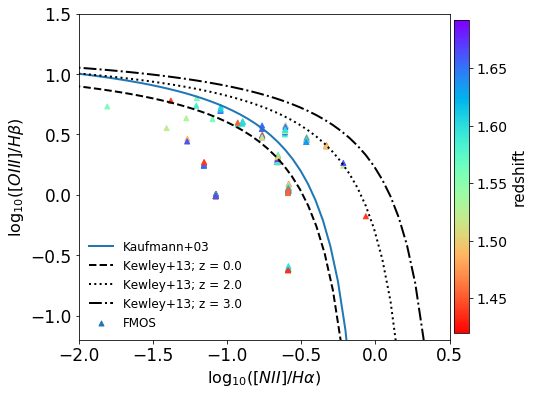

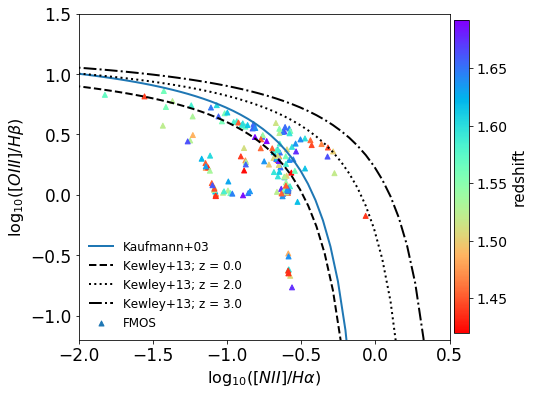

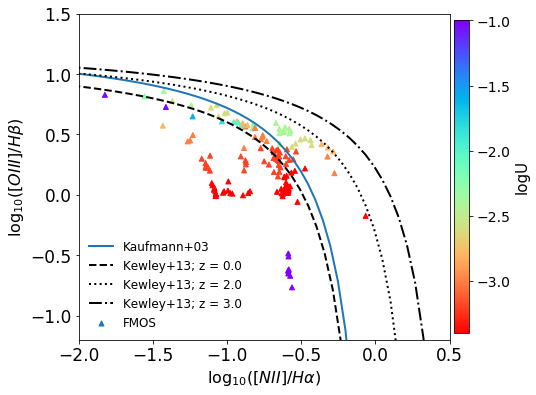

In [9]:
# ------------------------------------------------------------------------------    
# [NII]

# Kauffmann+03
def kaufmann03(log_NIIHa):
    return(0.61 / (log_NIIHa - 0.05) + 1.3)
# log([OIII]/Hb) = 0.61 / (log([NII]/Ha) - 0.05) + 1.3

# Kewley+01
def kewley01(log_NIIHa):
    return(0.61 / (log_NIIHa - 0.47) + 1.19)
# log([OIII]/Hb) = 0.61 / (log([NII]/Ha) - 0.47) + 1.19    (Kewley+01 line)

# Kewley+13
def kewley13(log_NIIHa, z):
    return(0.61 / (log_NIIHa - 0.02 - 0.1833*z) + 1.2 + 0.03*z)
# 0.61/(log([N II]/Hα) − 0.02 − 0.1833 ∗ z) +1.2 + 0.03 ∗ z     (Kewley+13 line)

log_NIIHa_kauf = np.linspace(-5, 0.0, 100)
log_NIIHa_kewl = np.linspace(-5, 0.49, 100)

plt.figure(figsize=(7,6))
# plt.scatter(np.log10(COSMOS['line.NII-658.4']/COSMOS['line.H-alpha']),\
#             np.log10(COSMOS['line.OIII-500.7']/COSMOS['line.H-beta']),\
#             s = 25, c = COSMOS['redshift'], cmap = plt.cm.viridis_r, marker = '^', label = 'FMOS')
plt.scatter(np.log10(COSMOS_cigale_1['best.line.NII-658.4']/COSMOS_cigale_1['best.line.H-alpha']),\
            np.log10(COSMOS_cigale_1['best.line.OIII-500.7']/COSMOS_cigale_1['best.line.H-beta']),\
            s = 25, c = COSMOS_cigale_1['best.universe.redshift'], cmap = plt.cm.rainbow_r, marker = '^', label = 'FMOS')
ce = plt.colorbar(fraction = 0.04, pad = 0.01)
ce.set_label(label = 'redshift', size = 15)
ce.ax.tick_params(labelsize = 14)
plt.plot(log_NIIHa_kauf, kaufmann03(log_NIIHa_kauf), c = 'k', ls = '-', lw = 2, color = 'C0', label = 'Kaufmann+03')
# plt.plot(log_NIIHa_kewl, kewley01(log_NIIHa_kewl), c = 'k', ls = '--', lw = 2)
plt.plot(log_NIIHa_kewl[:90], kewley13(log_NIIHa_kewl, z = 0)[:90], c = 'k', ls = '--', lw = 2, label = 'Kewley+13; z = 0.0')
plt.plot(log_NIIHa_kewl[:98], kewley13(log_NIIHa_kewl, z = 2)[:98], c = 'k', ls = ':', lw = 2, label = 'Kewley+13; z = 2.0')
plt.plot(log_NIIHa_kewl, kewley13(log_NIIHa_kewl, z = 3), c = 'k', ls = '-.', lw = 2, label = 'Kewley+13; z = 3.0')
# plt.plot(log_NIIHa_kewl, kewley13(log_NIIHa_kewl, z = 6), c = 'k', ls = '-', lw = 2, label = 'Kewley+13; z = 6.0')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.2, 1.5)
plt.xlabel(r'$\log_{10}$($[NII]/H\alpha$)', fontsize = 16)
plt.ylabel(r'$\log_{10}$($[OIII]/H\beta$)', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 17)
marker_size = 100
def update_prop(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([marker_size])

plt.legend(frameon = False, prop = {'size': 12}, loc = 'lower left',\
           handler_map={type(ce): HandlerPathCollection(update_func=update_prop)})

plt.figure(figsize=(7,6))
# plt.scatter(np.log10(COSMOS['line.NII-658.4']/COSMOS['line.H-alpha']),\
#             np.log10(COSMOS['line.OIII-500.7']/COSMOS['line.H-beta']),\
#             s = 25, c = COSMOS['redshift'], cmap = plt.cm.viridis_r, marker = '^', label = 'FMOS')
plt.scatter(np.log10(COSMOS_cigale_1['bayes.line.NII-658.4']/COSMOS_cigale_1['bayes.line.H-alpha']),\
            np.log10(COSMOS_cigale_1['bayes.line.OIII-500.7']/COSMOS_cigale_1['bayes.line.H-beta']),\
            s = 25, c = COSMOS_cigale_1['best.universe.redshift'], cmap = plt.cm.rainbow_r, marker = '^', label = 'FMOS')
ce = plt.colorbar(fraction = 0.04, pad = 0.01)
ce.set_label(label = 'redshift', size = 15)
ce.ax.tick_params(labelsize = 14)
plt.plot(log_NIIHa_kauf, kaufmann03(log_NIIHa_kauf), c = 'k', ls = '-', lw = 2, color = 'C0', label = 'Kaufmann+03')
# plt.plot(log_NIIHa_kewl, kewley01(log_NIIHa_kewl), c = 'k', ls = '--', lw = 2)
plt.plot(log_NIIHa_kewl[:90], kewley13(log_NIIHa_kewl, z = 0)[:90], c = 'k', ls = '--', lw = 2, label = 'Kewley+13; z = 0.0')
plt.plot(log_NIIHa_kewl[:98], kewley13(log_NIIHa_kewl, z = 2)[:98], c = 'k', ls = ':', lw = 2, label = 'Kewley+13; z = 2.0')
plt.plot(log_NIIHa_kewl, kewley13(log_NIIHa_kewl, z = 3), c = 'k', ls = '-.', lw = 2, label = 'Kewley+13; z = 3.0')
# plt.plot(log_NIIHa_kewl, kewley13(log_NIIHa_kewl, z = 6), c = 'k', ls = '-', lw = 2, label = 'Kewley+13; z = 6.0')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.2, 1.5)
plt.xlabel(r'$\log_{10}$($[NII]/H\alpha$)', fontsize = 16)
plt.ylabel(r'$\log_{10}$($[OIII]/H\beta$)', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 17)
marker_size = 100
def update_prop(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([marker_size])

plt.legend(frameon = False, prop = {'size': 12}, loc = 'lower left',\
           handler_map={type(ce): HandlerPathCollection(update_func=update_prop)})

plt.figure(figsize=(7,6))
# plt.scatter(np.log10(COSMOS['line.NII-658.4']/COSMOS['line.H-alpha']),\
#             np.log10(COSMOS['line.OIII-500.7']/COSMOS['line.H-beta']),\
#             s = 25, c = COSMOS['redshift'], cmap = plt.cm.viridis_r, marker = '^', label = 'FMOS')
plt.scatter(np.log10(COSMOS_cigale_1['bayes.line.NII-658.4']/COSMOS_cigale_1['bayes.line.H-alpha']),\
            np.log10(COSMOS_cigale_1['bayes.line.OIII-500.7']/COSMOS_cigale_1['bayes.line.H-beta']),\
            s = 25, c = COSMOS_cigale_1['best.nebular.logU'], cmap = plt.cm.rainbow_r, marker = '^', label = 'FMOS')
ce = plt.colorbar(fraction = 0.04, pad = 0.01)
ce.set_label(label = 'logU', size = 15)
ce.ax.tick_params(labelsize = 14)
plt.plot(log_NIIHa_kauf, kaufmann03(log_NIIHa_kauf), c = 'k', ls = '-', lw = 2, color = 'C0', label = 'Kaufmann+03')
# plt.plot(log_NIIHa_kewl, kewley01(log_NIIHa_kewl), c = 'k', ls = '--', lw = 2)
plt.plot(log_NIIHa_kewl[:90], kewley13(log_NIIHa_kewl, z = 0)[:90], c = 'k', ls = '--', lw = 2, label = 'Kewley+13; z = 0.0')
plt.plot(log_NIIHa_kewl[:98], kewley13(log_NIIHa_kewl, z = 2)[:98], c = 'k', ls = ':', lw = 2, label = 'Kewley+13; z = 2.0')
plt.plot(log_NIIHa_kewl, kewley13(log_NIIHa_kewl, z = 3), c = 'k', ls = '-.', lw = 2, label = 'Kewley+13; z = 3.0')
# plt.plot(log_NIIHa_kewl, kewley13(log_NIIHa_kewl, z = 6), c = 'k', ls = '-', lw = 2, label = 'Kewley+13; z = 6.0')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.2, 1.5)
plt.xlabel(r'$\log_{10}$($[NII]/H\alpha$)', fontsize = 16)
plt.ylabel(r'$\log_{10}$($[OIII]/H\beta$)', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 17)
marker_size = 100
def update_prop(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([marker_size])

plt.legend(frameon = False, prop = {'size': 12}, loc = 'lower left',\
           handler_map={type(ce): HandlerPathCollection(update_func=update_prop)})

/home/jvilla/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2448: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


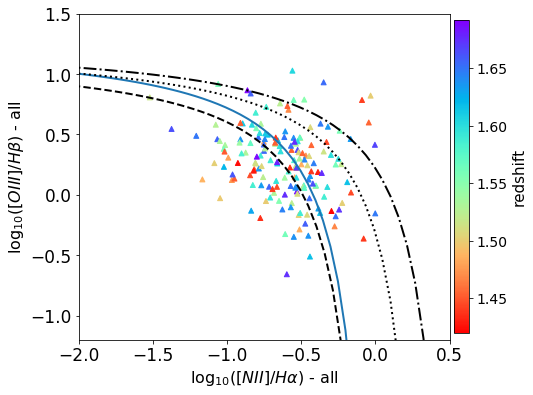

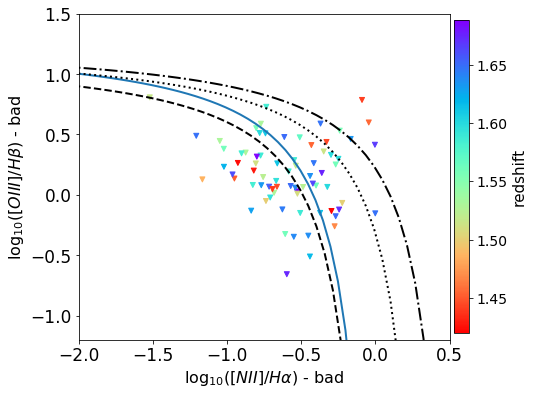

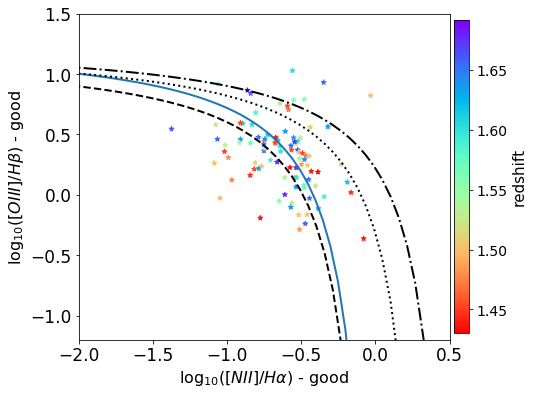

In [11]:
plt.figure(figsize=(7,6))
plt.scatter(np.log10(COSMOS['line.NII-658.4']/COSMOS['line.H-alpha']),\
            np.log10(COSMOS['line.OIII-500.7']/COSMOS['line.H-beta']),\
            s = 25, c = COSMOS['redshift'], cmap = plt.cm.rainbow_r, marker = '^', label = 'FMOS')
ce = plt.colorbar(fraction = 0.04, pad = 0.01)
ce.set_label(label = 'redshift', size = 15)
ce.ax.tick_params(labelsize = 14)
plt.plot(log_NIIHa_kauf, kaufmann03(log_NIIHa_kauf), c = 'k', ls = '-', lw = 2, color = 'C0', label = 'Kaufmann+03')
plt.plot(log_NIIHa_kewl[:90], kewley13(log_NIIHa_kewl, z = 0)[:90], c = 'k', ls = '--', lw = 2, label = 'Kewley+13; z = 0.0')
plt.plot(log_NIIHa_kewl[:98], kewley13(log_NIIHa_kewl, z = 2)[:98], c = 'k', ls = ':', lw = 2, label = 'Kewley+13; z = 2.0')
plt.plot(log_NIIHa_kewl, kewley13(log_NIIHa_kewl, z = 3), c = 'k', ls = '-.', lw = 2, label = 'Kewley+13; z = 3.0')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.2, 1.5)
plt.xlabel(r'$\log_{10}$($[NII]/H\alpha$) - all', fontsize = 16)
plt.ylabel(r'$\log_{10}$($[OIII]/H\beta$) - all', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 17)
marker_size = 100
def update_prop(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([marker_size])
    
plt.figure(figsize=(7,6))
# plt.scatter(np.log10(good_data['line.NII-658.4']/good_data['line.H-alpha']),\
#             np.log10(good_data['line.OIII-500.7']/good_data['line.H-beta']),\
#             s = 25, c = good_data['redshift'], cmap = plt.cm.rainbow_r, marker = '*', label = 'FMOS')
plt.scatter(np.log10(bad_data['line.NII-658.4']/bad_data['line.H-alpha']),\
            np.log10(bad_data['line.OIII-500.7']/bad_data['line.H-beta']),\
            s = 25, c = bad_data['redshift'], cmap = plt.cm.rainbow_r, marker = 'v', label = 'FMOS-bad')
ce = plt.colorbar(fraction = 0.04, pad = 0.01)
ce.set_label(label = 'redshift', size = 15)
ce.ax.tick_params(labelsize = 14)
plt.plot(log_NIIHa_kauf, kaufmann03(log_NIIHa_kauf), c = 'k', ls = '-', lw = 2, color = 'C0', label = 'Kaufmann+03')
plt.plot(log_NIIHa_kewl[:90], kewley13(log_NIIHa_kewl, z = 0)[:90], c = 'k', ls = '--', lw = 2, label = 'Kewley+13; z = 0.0')
plt.plot(log_NIIHa_kewl[:98], kewley13(log_NIIHa_kewl, z = 2)[:98], c = 'k', ls = ':', lw = 2, label = 'Kewley+13; z = 2.0')
plt.plot(log_NIIHa_kewl, kewley13(log_NIIHa_kewl, z = 3), c = 'k', ls = '-.', lw = 2, label = 'Kewley+13; z = 3.0')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.2, 1.5)
plt.xlabel(r'$\log_{10}$($[NII]/H\alpha$) - bad', fontsize = 16)
plt.ylabel(r'$\log_{10}$($[OIII]/H\beta$) - bad', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 17)
marker_size = 100
def update_prop(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([marker_size])
    
plt.figure(figsize=(7,6))
plt.scatter(np.log10(good_data['line.NII-658.4']/good_data['line.H-alpha']),\
            np.log10(good_data['line.OIII-500.7']/good_data['line.H-beta']),\
            s = 25, c = good_data['redshift'], cmap = plt.cm.rainbow_r, marker = '*', label = 'FMOS-good')
# plt.scatter(np.log10(bad_data['line.NII-658.4']/bad_data['line.H-alpha']),\
#             np.log10(bad_data['line.OIII-500.7']/bad_data['line.H-beta']),\
#             s = 25, c = bad_data['redshift'], cmap = plt.cm.rainbow_r, marker = 'v', label = 'FMOS')
ce = plt.colorbar(fraction = 0.04, pad = 0.01)
ce.set_label(label = 'redshift', size = 15)
ce.ax.tick_params(labelsize = 14)
plt.plot(log_NIIHa_kauf, kaufmann03(log_NIIHa_kauf), c = 'k', ls = '-', lw = 2, color = 'C0', label = 'Kaufmann+03')
plt.plot(log_NIIHa_kewl[:90], kewley13(log_NIIHa_kewl, z = 0)[:90], c = 'k', ls = '--', lw = 2, label = 'Kewley+13; z = 0.0')
plt.plot(log_NIIHa_kewl[:98], kewley13(log_NIIHa_kewl, z = 2)[:98], c = 'k', ls = ':', lw = 2, label = 'Kewley+13; z = 2.0')
plt.plot(log_NIIHa_kewl, kewley13(log_NIIHa_kewl, z = 3), c = 'k', ls = '-.', lw = 2, label = 'Kewley+13; z = 3.0')
plt.xlim(-2.0, 0.5)
plt.ylim(-1.2, 1.5)
plt.xlabel(r'$\log_{10}$($[NII]/H\alpha$) - good', fontsize = 16)
plt.ylabel(r'$\log_{10}$($[OIII]/H\beta$) - good', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 17)
marker_size = 100
def update_prop(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([marker_size])    

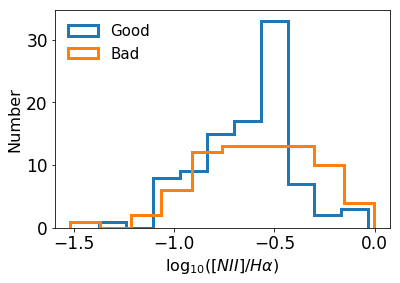

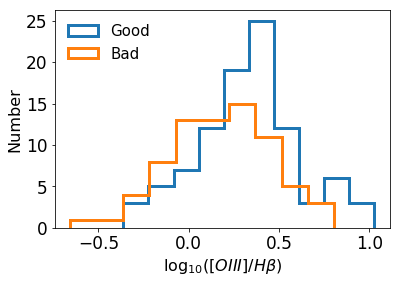

In [13]:
plt.figure()
plt.hist(np.log10(good_data['line.NII-658.4']/good_data['line.H-alpha']), histtype = 'step', lw = 3, label = 'Good')    
plt.hist(np.log10(bad_data['line.NII-658.4']/bad_data['line.H-alpha']), histtype = 'step', lw = 3, label = 'Bad')    
plt.xlabel(r'$\log_{10}$($[NII]/H\alpha$)', fontsize = 16)
plt.ylabel('Number', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 17)
plt.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'upper left')

plt.figure()
plt.hist(np.log10(good_data['line.OIII-500.7']/good_data['line.H-beta']), histtype = 'step', lw = 3, label = 'Good')
plt.hist(np.log10(bad_data['line.OIII-500.7']/bad_data['line.H-beta']), histtype = 'step', lw = 3, label = 'Bad')
plt.xlabel(r'$\log_{10}$($[OIII]/H\beta$)', fontsize = 16)
plt.ylabel('Number', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 17)
plt.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'upper left')

# $\chi^2$ distributions are check for both attenuation models

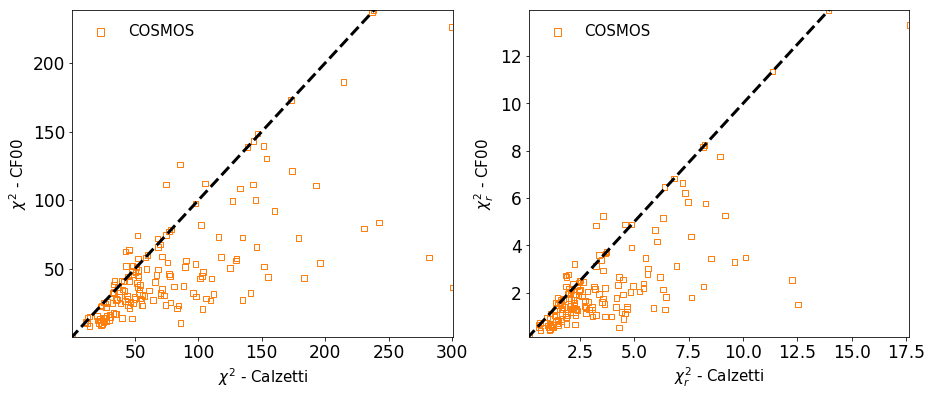

In [14]:
chi_square = ['best.chi_square','best.reduced_chi_square']

fig, ((axA, axB)) = plt.subplots(figsize=(15,6), nrows=1, ncols=2)

axA.scatter(COSMOS_cigale_1[chi_square[0]], COSMOS_cigale_3[chi_square[0]], marker = 's', s = 30,\
            facecolor = 'none', edgecolors = 'C1', label = 'COSMOS')
# axA.scatter(GOODSS_CF00_results[chi_square[0]], GOODSS_starburst_results[chi_square[0]], marker = 's', s = 30,\
#             facecolor = 'none', edgecolors = 'C2', label = 'GOODSS')
axA.plot(np.linspace(min(COSMOS_cigale_1[chi_square[0]])-100,max(COSMOS_cigale_1[chi_square[0]])+100, 100),\
         np.linspace(min(COSMOS_cigale_1[chi_square[0]])-100,max(COSMOS_cigale_1[chi_square[0]])+100, 100),\
         '--', lw = 3, c = 'k')
axA.set_xlim(min(COSMOS_cigale_1[chi_square[0]]),max(COSMOS_cigale_1[chi_square[0]]))
axA.set_ylim(min(COSMOS_cigale_3[chi_square[0]]),max(COSMOS_cigale_3[chi_square[0]]))
axA.set_xlabel(r'$\chi^2$ - Calzetti', fontsize = 15)
axA.set_ylabel(r'$\chi^2$ - CF00', fontsize = 15)
axA.tick_params(axis = 'both', which = 'major', labelsize = 17)
axA.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'upper left')

axB.scatter(COSMOS_cigale_1[chi_square[1]], COSMOS_cigale_3[chi_square[1]], marker = 's', s = 30,\
            facecolor = 'none', edgecolors = 'C1', label = 'COSMOS')
# axB.scatter(GOODSS_CF00_results[chi_square[1]], GOODSS_starburst_results[chi_square[1]], marker = 's', s = 30,\
#             facecolor = 'none', edgecolors = 'C2', label = 'GOODSS')
axB.plot(np.linspace(min(COSMOS_cigale_1[chi_square[1]])-100,max(COSMOS_cigale_1[chi_square[1]])+100, 100),\
         np.linspace(min(COSMOS_cigale_1[chi_square[1]])-100,max(COSMOS_cigale_1[chi_square[1]])+100, 100),\
         '--', lw = 3, c = 'k')
axB.set_xlim(min(COSMOS_cigale_1[chi_square[1]]),max(COSMOS_cigale_1[chi_square[1]]))
axB.set_ylim(min(COSMOS_cigale_3[chi_square[1]]),max(COSMOS_cigale_3[chi_square[1]]))
axB.set_xlabel(r'$\chi^2_r$ - Calzetti', fontsize = 15)
axB.set_ylabel(r'$\chi^2_r$ - CF00', fontsize = 15)
axB.tick_params(axis = 'both', which = 'major', labelsize = 17)
axB.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'upper left')

# Attenuation parameters behavior

In [15]:
#===================================================================================================================
'''Attenuation Law Parameters'''
#===================================================================================================================

# COSMOS
x_err = COSMOS_cigale['bayes.attenuation.mu_err']
y_err = COSMOS_starburst_results['bayes.attenuation.E_BV_factor_err']

x_err_1 = COSMOS_CF00_results['bayes.attenuation.slope_ISM_err']
y_err_1 = COSMOS_starburst_results['bayes.attenuation.powerlaw_slope_err']

fig, ((axA, axB)) = plt.subplots(figsize = (14, 6), ncols = 2, nrows = 1)

#Differential attenuation mu versus E(B-V)star/E(B-V)line
axA.errorbar(COSMOS_cigale['bayes.attenuation.mu'], COSMOS_starburst_results['bayes.attenuation.E_BV_factor'],\
             y_err, x_err, c = 'C1', fmt = 'o', elinewidth = 0.1)
axA.axvline(0.30, linestyle = '--', linewidth = 3, c = 'k')
axA.axhline(0.44, linestyle = '--', linewidth = 3, c = 'k')
axA.set_title('COSMOS', fontsize = 15)
axA.set_xlabel(r'$\mu$', fontsize = 15)
axA.set_ylabel(r'E(B-V)$_{star}$ / E(B-V)$_{line}$', fontsize = 15)
axA.tick_params(axis = 'both', which = 'major', labelsize = 15)

#Slopes: delta for COSMOS_starburst_results-like and n^ISM for DBPL-free
# axB.scatter(COSMOS_CF00_results['bayes.attenuation.slope_ISM'], COSMOS_starburst_results['bayes.attenuation.powerlaw_slope'])
axB.errorbar(COSMOS_CF00_results['bayes.attenuation.slope_ISM'], COSMOS_starburst_results['bayes.attenuation.powerlaw_slope'],\
            y_err_1, x_err_1, c = 'orange', fmt = 'o', elinewidth = 0.1)
axB.axvline(-0.7, linestyle = '--', linewidth = 3, c = 'k')
axB.axhline(0.0, linestyle = '--', linewidth = 3, c = 'k')
axB.set_xlabel(r'n$^{ISM}$', fontsize = 15)
axB.set_ylabel(r'$\delta$', fontsize = 15)
axB.tick_params(axis = 'both', which = 'major', labelsize = 15)

#GOODSS
'''
x_err = GOODSS_CF00_results['bayes.attenuation.mu_err']
y_err = GOODSS_starburst_results['bayes.attenuation.E_BV_factor_err']

x_err_1 = GOODSS_CF00_results['bayes.attenuation.slope_ISM_err']
y_err_1 = GOODSS_starburst_results['bayes.attenuation.powerlaw_slope_err']

fig, ((axA, axB)) = plt.subplots(figsize = (14, 6), ncols = 2, nrows = 1)

#Differential attenuation mu versus E(B-V)star/E(B-V)line
axA.errorbar(GOODSS_CF00_results['bayes.attenuation.mu'], GOODSS_starburst_results['bayes.attenuation.E_BV_factor'],\
             y_err, x_err, c = 'C2', fmt = 'o', elinewidth = 0.1)
axA.axvline(0.30, linestyle = '--', linewidth = 3, c = 'k')
axA.axhline(0.44, linestyle = '--', linewidth = 3, c = 'k')
axA.set_title('GOODS-S', fontsize = 15)
axA.set_xlabel(r'$\mu$', fontsize = 15)
axA.set_ylabel(r'E(B-V)$_{star}$ / E(B-V)$_{line}$', fontsize = 15)
axA.tick_params(axis = 'both', which = 'major', labelsize = 15)

#Slopes: delta for GOODSS_starburst_results-like and n^ISM for DBPL-free
# axB.scatter(GOODSS_CF00_results['bayes.attenuation.slope_ISM'], GOODSS_starburst_results['bayes.attenuation.powerlaw_slope'])
axB.errorbar(GOODSS_CF00_results['bayes.attenuation.slope_ISM'], GOODSS_starburst_results['bayes.attenuation.powerlaw_slope'],\
            y_err_1, x_err_1, c = 'C3', fmt = 'o', elinewidth = 0.1)
axB.axvline(-0.7, linestyle = '--', linewidth = 3, c = 'k')
axB.axhline(0.0, linestyle = '--', linewidth = 3, c = 'k')
axB.set_xlabel(r'n$^{ISM}$', fontsize = 15)
axB.set_ylabel(r'$\delta$', fontsize = 15)
axB.tick_params(axis = 'both', which = 'major', labelsize = 15) '''

# Extinction for both attenuation models

In [212]:
def Calzetti_up_new(L):
    return(2.400*(-2.488+1.803/L-0.261/L**2 + 0.0145/L**3) + 3.67)
def Calzetti_low_new(L):
    return(2.300*(-1.996+1.135/L-0.0124/L**2) + 3.67)

def Calzetti_up(L, Rv):
    return(2.659*(-1.857+1.040/L)+Rv)
def Calzetti_low(L, Rv):
    return(2.659*(-2.156+1.509/L-0.198/L**2+0.011/L**3)+Rv)

up  = np.linspace(0.63, 2.20, 100)
low = np.linspace(0.12, 0.63, 100)

print('Old')
print('Ha %.2f'%(Calzetti_up(0.6563, 3.1)))
print('OIII %.2f'%(Calzetti_low(0.5007, 3.1)))

print('\nNew')
print('Ha %.2f'%(Calzetti_up_new(0.6563)))
print('OIII %.2f'%(Calzetti_low_new(0.5007)))

Old
Ha 2.38
OIII 3.51

New
Ha 2.96
OIII 4.18


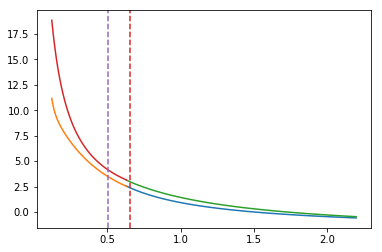

In [213]:
plt.plot(up, Calzetti_up(up, 3.1))
plt.plot(low, Calzetti_low(low, 3.1))
plt.plot(up, Calzetti_up_new(up))
plt.plot(low, Calzetti_low_new(low))
plt.axvline(x = 0.6563, ls ='--', color = 'C3')
plt.axvline(x = 0.5007, ls = '--', color = 'C4')

In [215]:
# All the data

COSMOS_starburst_results = COSMOS_cigale_1
COSMOS_CF00_results      = COSMOS_cigale_3

#===================================================================================================================
'''H_alpha flux comaprison for observed and model data'''
#===================================================================================================================
Milky_Way_Ha  = 2.38

#CF00

#A_Halpha (0.65628 micrometers) for CF00(GOOD data)
# A_BC_COSMOS_CF00   = A_line(A_v = COSMOS_CF00_results['best.attenuation.Av_BC'], Lambda = 0.65628, Lambda_v = 0.55,\
#                      n = COSMOS_CF00_results['best.attenuation.slope_BC'])
# A_ISM_COSMOS_CF00  = A_line(A_v = COSMOS_CF00_results['best.attenuation.Av_ISM'], Lambda = 0.65628, Lambda_v = 0.55,\
#                      n = COSMOS_CF00_results['best.attenuation.slope_ISM'])
# A_COSMOS_CF00 = A_BC_COSMOS_CF00 + A_ISM_COSMOS_CF00

A_COSMOS_CF00 = COSMOS_CF00_results['best.attenuation.V_B90']*(0.65628/0.55)**-0.7

print('CF00 attenuation in Halpha\n')
print('The mean values of CF00-COSMOS-Halpha is: %0.2f'%np.mean(A_COSMOS_CF00))

# Starburst

#A_Halpha (0.65628 micrometers) for starburst(GOOD data)
# A_COSMOS_starburst   = Milky_Way*COSMOS_starburst_results_1['best.attenuation.E_BV_lines']
print('\nModified starburst attenuation in Halpha\n')
A_COSMOS_calzetti   = Milky_Way_Ha*COSMOS_starburst_results['best.attenuation.E_BV_lines']
print('The mean values of best calzetti-COSMOS-Halpha is: %0.2f'%np.mean(A_COSMOS_calzetti))

#===================================================================================================================
'''[OIII] flux comaprison for observed and model data'''
#===================================================================================================================
Milky_Way_OIII  = 3.51

#CF00
#[OIII] (0.5007 micrometers) for CF00(GOOD data)
# A_BC_COSMOS_CF00_OIII   = A_line(A_v = COSMOS_CF00_results['best.attenuation.Av_BC'], Lambda = 0.5007, Lambda_v = 0.55,\
#                                  n = COSMOS_CF00_results['best.attenuation.slope_BC'])
# A_ISM_COSMOS_CF00_OIII  = A_line(A_v = COSMOS_CF00_results['best.attenuation.Av_ISM'], Lambda = 0.5007, Lambda_v = 0.55,\
#                                  n = COSMOS_CF00_results['best.attenuation.slope_ISM'])
# A_COSMOS_CF00_OIII      = A_BC_COSMOS_CF00_OIII + A_ISM_COSMOS_CF00_OIII

A_COSMOS_CF00_OIII = COSMOS_CF00_results['best.attenuation.V_B90']*(0.5007/0.55)**-0.7

print('\nCF00 attenuation in [OIII]\n')
print('The mean values of CF00-COSMOS-[OIII] is: %0.2f'%np.mean(A_COSMOS_CF00_OIII))

# Starburst
#[OIII] (0.5007 micrometers) for starburst(GOOD data)
print('\nModified starburst attenuation in [OIII]\n')
A_COSMOS_starburst_OIII   = Milky_Way_OIII*COSMOS_starburst_results['best.attenuation.E_BV_lines']
print('The mean values of starburst-COSMOS-[OIII] is: %0.2f'%np.mean(A_COSMOS_starburst_OIII))

CF00 attenuation in Halpha

The mean values of CF00-COSMOS-Halpha is: 0.82

Modified starburst attenuation in Halpha

The mean values of best calzetti-COSMOS-Halpha is: 0.91

CF00 attenuation in [OIII]

The mean values of CF00-COSMOS-[OIII] is: 0.99

Modified starburst attenuation in [OIII]

The mean values of starburst-COSMOS-[OIII] is: 1.34


In [216]:
# Only good data filtered by Ha/Hb

COSMOS_starburst_results_1 = COSMOS_cigale_good_1
COSMOS_CF00_results_1      = COSMOS_cigale_good_3

#===================================================================================================================
'''H_alpha flux comaprison for observed and model data'''
#===================================================================================================================
Milky_Way_Ha  = 2.38

#CF00

#A_Halpha (0.65628 micrometers) for CF00(GOOD data)
# A_BC_COSMOS_CF00   = A_line(A_v = COSMOS_CF00_results['best.attenuation.Av_BC'], Lambda = 0.65628, Lambda_v = 0.55,\
#                      n = COSMOS_CF00_results['best.attenuation.slope_BC'])
# A_ISM_COSMOS_CF00  = A_line(A_v = COSMOS_CF00_results['best.attenuation.Av_ISM'], Lambda = 0.65628, Lambda_v = 0.55,\
#                      n = COSMOS_CF00_results['best.attenuation.slope_ISM'])
# A_COSMOS_CF00 = A_BC_COSMOS_CF00 + A_ISM_COSMOS_CF00

A_COSMOS_CF00 = COSMOS_CF00_results_1['best.attenuation.V_B90']*(0.65628/0.55)**-0.7

print('CF00 attenuation in Halpha\n')
print('The mean values of CF00-COSMOS-Halpha is: %0.2f'%np.mean(A_COSMOS_CF00))

# Starburst

#A_Halpha (0.65628 micrometers) for starburst(GOOD data)
# A_COSMOS_starburst   = Milky_Way*COSMOS_starburst_results_1['best.attenuation.E_BV_lines']
print('\nModified starburst attenuation in Halpha\n')
A_COSMOS_calzetti   = Milky_Way_Ha*COSMOS_starburst_results_1['best.attenuation.E_BV_lines']
print('The mean values of best calzetti-COSMOS-Halpha is: %0.2f'%np.mean(A_COSMOS_calzetti))

#===================================================================================================================
'''[OIII] flux comaprison for observed and model data'''
#===================================================================================================================
Milky_Way_OIII  = 3.51

#CF00
#[OIII] (0.5007 micrometers) for CF00(GOOD data)
# A_BC_COSMOS_CF00_OIII   = A_line(A_v = COSMOS_CF00_results['best.attenuation.Av_BC'], Lambda = 0.5007, Lambda_v = 0.55,\
#                                  n = COSMOS_CF00_results['best.attenuation.slope_BC'])
# A_ISM_COSMOS_CF00_OIII  = A_line(A_v = COSMOS_CF00_results['best.attenuation.Av_ISM'], Lambda = 0.5007, Lambda_v = 0.55,\
#                                  n = COSMOS_CF00_results['best.attenuation.slope_ISM'])
# A_COSMOS_CF00_OIII      = A_BC_COSMOS_CF00_OIII + A_ISM_COSMOS_CF00_OIII

A_COSMOS_CF00_OIII = COSMOS_CF00_results_1['best.attenuation.V_B90']*(0.5007/0.55)**-0.7

print('\nCF00 attenuation in [OIII]\n')
print('The mean values of CF00-COSMOS-[OIII] is: %0.2f'%np.mean(A_COSMOS_CF00_OIII))

# Starburst
#[OIII] (0.5007 micrometers) for starburst(GOOD data)
print('\nModified starburst attenuation in [OIII]\n')
A_COSMOS_starburst_OIII   = Milky_Way_OIII*COSMOS_starburst_results_1['best.attenuation.E_BV_lines']
print('The mean values of starburst-COSMOS-[OIII] is: %0.2f'%np.mean(A_COSMOS_starburst_OIII))

CF00 attenuation in Halpha

The mean values of CF00-COSMOS-Halpha is: 0.94

Modified starburst attenuation in Halpha

The mean values of best calzetti-COSMOS-Halpha is: 1.05

CF00 attenuation in [OIII]

The mean values of CF00-COSMOS-[OIII] is: 1.13

Modified starburst attenuation in [OIII]

The mean values of starburst-COSMOS-[OIII] is: 1.55


# SFRs estimates from H$_\alpha$ and [OIII]

In [137]:
# From Suzuki et al., 2016
# L_Ha is already in erg s^-1

def SFR_kennicutt_98(L_Ha):
    return( np.multiply(7.9e-42, L_Ha) )

def SFR_kennicutt_98_corrected(L_Ha, A):
    return( np.multiply(7.9e-42*10**(0.4*A), L_Ha) )
#     return( np.multiply(7.9e-42/A, L_Ha) )

In [138]:
X = np.linspace(30, 50, 100)
X_1 = np.linspace(10**30, 10**50, 100)
X_2 = np.linspace(-10, 10, 100)

A_Ha_sb     = 0.91
A_OIII_sb   = 1.34
A_Ha_CF00   = 0.82
A_OIII_CF00 = 0.99

In [224]:
bad_data_Halpha_sample  = flux_to_luminosity(flux=bad_data['line.H-alpha'], z=bad_data['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)
bad_data_Hbeta_sample   = flux_to_luminosity(flux=bad_data['line.H-beta'], z=bad_data['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)
bad_data_NII_sample     = flux_to_luminosity(flux=bad_data['line.NII-658.4'], z=bad_data['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)
bad_data_OIII_sample    = flux_to_luminosity(flux=bad_data['line.OIII-500.7'], z=bad_data['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)

bad_data_Halpha_sample_sb_corr  = flux_to_luminosity(flux=bad_data['line.H-alpha']*10**(0.4*A_Ha_sb), z=bad_data['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)
# bad_data_Hbeta_sample_corr   = flux_to_luminosity(flux=bad_data['line.H-beta']*10**(0.4*A_Ha_sb), z=bad_data['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)
# bad_data_NII_sample_corr     = flux_to_luminosity(flux=bad_data['line.NII-658.4']*10**(0.4*A_Ha_sb), z=bad_data['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)
bad_data_OIII_sample_sb_corr    = flux_to_luminosity(flux=bad_data['line.OIII-500.7']*10**(0.4*A_OIII_sb), z=bad_data['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)


bad_data_Halpha_sample_CF00_corr  = flux_to_luminosity(flux=bad_data['line.H-alpha']*10**(0.4*A_Ha_CF00), z=bad_data['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)
# bad_data_Hbeta_sample_CF00_corr   = flux_to_luminosity(flux=bad_data['line.H-beta']*10**(0.4*A_Ha_CF00), z=bad_data['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)
# bad_data_NII_sample_CF00_corr     = flux_to_luminosity(flux=bad_data['line.NII-658.4']*10**(0.4*A_Ha_CF00), z=bad_data['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)
bad_data_OIII_sample_CF00_corr    = flux_to_luminosity(flux=bad_data['line.OIII-500.7']*10**(0.4*A_OIII_CF00), z=bad_data['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)

In [158]:
good_data_Halpha_sample  = flux_to_luminosity(flux=good_data['line.H-alpha'], z=good_data['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)
good_data_Hbeta_sample   = flux_to_luminosity(flux=good_data['line.H-beta'], z=good_data['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)
good_data_NII_sample     = flux_to_luminosity(flux=good_data['line.NII-658.4'], z=good_data['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)
good_data_OIII_sample    = flux_to_luminosity(flux=good_data['line.OIII-500.7'], z=good_data['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)

good_data_Halpha_sample_sb_corr  = flux_to_luminosity(flux=good_data['line.H-alpha']*10**(0.4*A_Ha_sb), z=good_data['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)
# good_data_Hbeta_sample_corr   = flux_to_luminosity(flux=good_data['line.H-beta']*10**(0.4*A_Ha_sb), z=good_data['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)
# good_data_NII_sample_corr     = flux_to_luminosity(flux=good_data['line.NII-658.4']*10**(0.4*A_Ha_sb), z=good_data['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)
good_data_OIII_sample_sb_corr    = flux_to_luminosity(flux=good_data['line.OIII-500.7']*10**(0.4*A_OIII_sb), z=good_data['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)


good_data_Halpha_sample_CF00_corr  = flux_to_luminosity(flux=good_data['line.H-alpha']*10**(0.4*A_Ha_CF00), z=good_data['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)
# good_data_Hbeta_sample_CF00_corr   = flux_to_luminosity(flux=good_data['line.H-beta']*10**(0.4*A_Ha_CF00), z=good_data['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)
# good_data_NII_sample_CF00_corr     = flux_to_luminosity(flux=good_data['line.NII-658.4']*10**(0.4*A_Ha_CF00), z=good_data['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)
good_data_OIII_sample_CF00_corr    = flux_to_luminosity(flux=good_data['line.OIII-500.7']*10**(0.4*A_OIII_CF00), z=good_data['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)

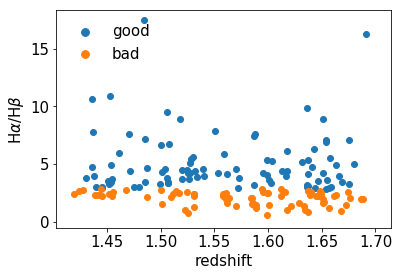

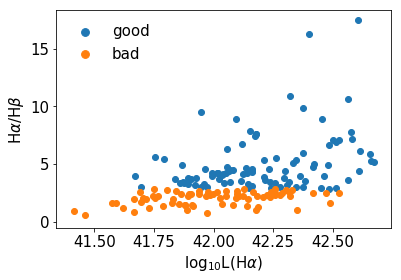

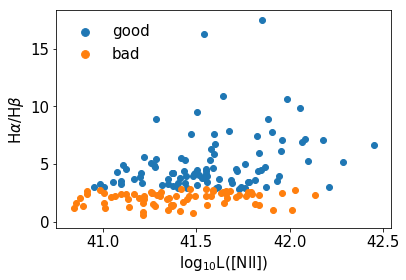

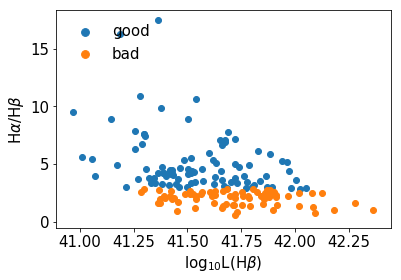

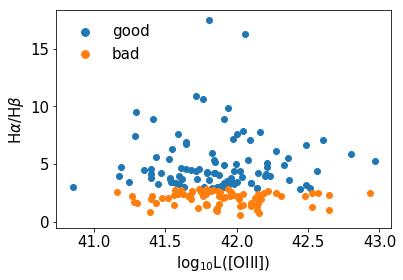

In [234]:
plt.figure()
plt.scatter(good_data['redshift'], good_data['line.H-alpha']/good_data['line.H-beta'], label = 'good')
plt.scatter(bad_data['redshift'], bad_data['line.H-alpha']/bad_data['line.H-beta'], label = 'bad')
plt.ylabel(r'H$\alpha$/H$\beta$', fontsize = 15)
plt.xlabel(r'redshift', fontsize = 15)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'upper left')

plt.figure()
plt.scatter(np.log10(good_data_Halpha_sample), good_data['line.H-alpha']/good_data['line.H-beta'], label = 'good')
plt.scatter(np.log10(bad_data_Halpha_sample), bad_data['line.H-alpha']/bad_data['line.H-beta'], label = 'bad')
plt.ylabel(r'H$\alpha$/H$\beta$', fontsize = 15)
plt.xlabel(r'log$_{10}$L(H$\alpha$)', fontsize = 15)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'upper left')

plt.figure()
plt.scatter(np.log10(good_data_NII_sample), good_data['line.H-alpha']/good_data['line.H-beta'], label = 'good')
plt.scatter(np.log10(bad_data_NII_sample), bad_data['line.H-alpha']/bad_data['line.H-beta'], label = 'bad')
plt.ylabel(r'H$\alpha$/H$\beta$', fontsize = 15)
plt.xlabel(r'log$_{10}$L([NII])', fontsize = 15)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'upper left')

plt.figure()
plt.scatter(np.log10(good_data_Hbeta_sample), good_data['line.H-alpha']/good_data['line.H-beta'], label = 'good')
plt.scatter(np.log10(bad_data_Hbeta_sample), bad_data['line.H-alpha']/bad_data['line.H-beta'], label = 'bad')
plt.ylabel(r'H$\alpha$/H$\beta$', fontsize = 15)
plt.xlabel(r'log$_{10}$L(H$\beta$)', fontsize = 15)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'upper left')

plt.figure()
plt.scatter(np.log10(good_data_OIII_sample), good_data['line.H-alpha']/good_data['line.H-beta'], label = 'good')
plt.scatter(np.log10(bad_data_OIII_sample), bad_data['line.H-alpha']/bad_data['line.H-beta'], label = 'bad')
plt.ylabel(r'H$\alpha$/H$\beta$', fontsize = 15)
plt.xlabel(r'log$_{10}$L([OIII])', fontsize = 15)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'upper left')

/home/jvilla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/home/jvilla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


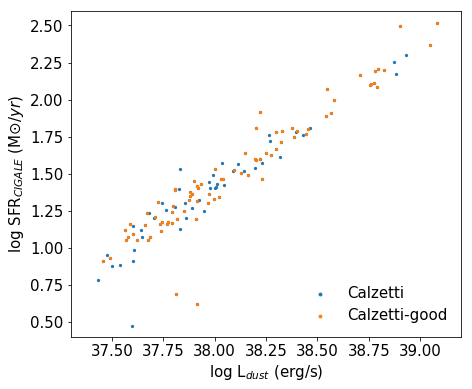

In [159]:
plt.figure(figsize=(7,6))
plt.scatter(np.log10(COSMOS_cigale_1['best.dust.luminosity']), np.log10(COSMOS_cigale_1['best.sfh.sfr']),\
            s = 5, label = 'Calzetti')
plt.scatter(np.log10(COSMOS_cigale_good_1['best.dust.luminosity']), np.log10(COSMOS_cigale_good_1['best.sfh.sfr']),\
            s = 5, label = 'Calzetti-good')
plt.ylim(0.4, 2.6)
plt.xlim(37.3, 39.2)
plt.xlabel(r'log L$_{dust}$ (erg/s)', fontsize = 15)
plt.ylabel(r'log SFR$_{CIGALE}$ (M$\odot/yr$)', fontsize = 15)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'lower right')

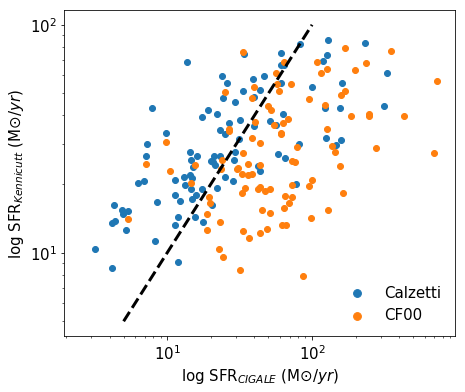

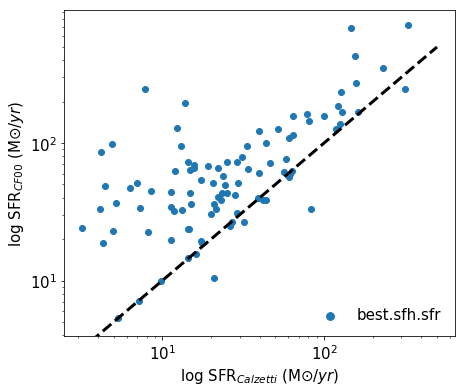

In [173]:
line   = np.linspace(5, 100, 100)
line_1 = np.linspace(0, 500, 100)

plt.figure(figsize=(7,6))
plt.scatter(COSMOS_cigale_good_1['best.sfh.sfr'], SFR_kennicutt_98(good_data_Halpha_sample_sb_corr), label = 'Calzetti')
plt.scatter(COSMOS_cigale_good_3['best.sfh.sfr'], SFR_kennicutt_98(good_data_Halpha_sample_CF00_corr), label = 'CF00')
plt.plot(line, line, ls = '--', lw = 3, c = 'k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'log SFR$_{CIGALE}$ (M$\odot/yr$)', fontsize = 15)
plt.ylabel(r'log SFR$_{Kennicutt}$ (M$\odot/yr$)', fontsize = 15)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'lower right')

plt.figure(figsize=(7,6))
plt.scatter(COSMOS_cigale_good_1['best.sfh.sfr'], COSMOS_cigale_good_3['best.sfh.sfr'])
plt.plot(line_1, line_1, ls = '--', lw = 3, c = 'k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'log SFR$_{Calzetti}$ (M$\odot/yr$)', fontsize = 15)
plt.ylabel(r'log SFR$_{CF00}$ (M$\odot/yr$)', fontsize = 15)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'lower right')

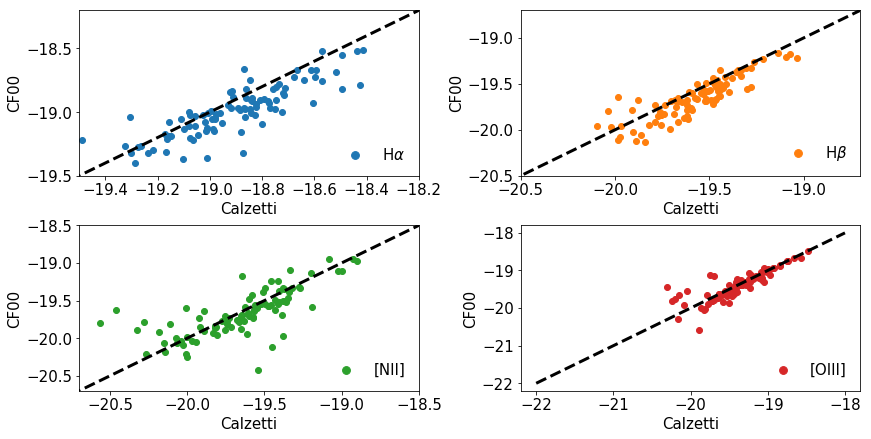

In [249]:
line_3 = np.linspace(-22, -18) 

fig, ((axA, axB), (axC, axD)) = plt.subplots(figsize=(14,7), nrows=2, ncols=2)
fig.subplots_adjust(hspace = 0.3, wspace = 0.3)

axA.scatter(np.log10(COSMOS_cigale_good_1['best.line.H-alpha']), \
            np.log10(COSMOS_cigale_good_3['best.line.H-alpha']), c = 'C0', label = r'H$\alpha$')
axA.plot(line_3, line_3, ls = '--', lw = 3, c = 'k')
axA.set_xlim(-19.5, -18.2)
axA.set_ylim(-19.5, -18.2)
axA.set_xlabel(r'Calzetti', fontsize = 15)
axA.set_ylabel(r'CF00', fontsize = 15)
axA.tick_params(axis = 'both', which = 'major', labelsize = 15)
axA.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'lower right')

axB.scatter(np.log10(COSMOS_cigale_good_1['best.line.H-beta']), \
            np.log10(COSMOS_cigale_good_3['best.line.H-beta']), c = 'C1', label = r'H$\beta$')
axB.plot(line_3, line_3, ls = '--', lw = 3, c = 'k')
axB.set_xlim(-20.5, -18.7)
axB.set_ylim(-20.5, -18.7)
axB.set_xlabel(r'Calzetti', fontsize = 15)
axB.set_ylabel(r'CF00', fontsize = 15)
axB.tick_params(axis = 'both', which = 'major', labelsize = 15)
axB.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'lower right')

axC.scatter(np.log10(COSMOS_cigale_good_1['best.line.NII-658.4']), \
            np.log10(COSMOS_cigale_good_3['best.line.NII-658.4']), c = 'C2', label = r'[NII]')
axC.plot(line_3, line_3, ls = '--', lw = 3, c = 'k')
axC.set_xlim(-20.7, -18.5)
axC.set_ylim(-20.7, -18.5)
axC.set_xlabel(r'Calzetti', fontsize = 15)
axC.set_ylabel(r'CF00', fontsize = 15)
axC.tick_params(axis = 'both', which = 'major', labelsize = 15)
axC.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'lower right')

axD.scatter(np.log10(COSMOS_cigale_good_1['best.line.OIII-500.7']), \
            np.log10(COSMOS_cigale_good_3['best.line.OIII-500.7']), c = 'C3', label = r'[OIII]')
axD.plot(line_3, line_3, ls = '--', lw = 3, c = 'k')
# axD.set_xlim(-20.5, -18.7)
# axD.set_ylim(-20.5, -18.7)
axD.set_xlabel(r'Calzetti', fontsize = 15)
axD.set_ylabel(r'CF00', fontsize = 15)
axD.tick_params(axis = 'both', which = 'major', labelsize = 15)
axD.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'lower right')

In [192]:
# 3D-HST old data to check if they follow the relation

COSMOS_sample = Table.read('/data/3DHST_Data/Final_samples/'
                          'COSMOS_HaOIII_all_NoAGNs_lines.fits', format = 'fits')

GOODSS_sample = Table.read('/data/3DHST_Data/Final_samples/'
                          'GOODSS_HaOIII_all_NoAGNs_lines.fits', format = 'fits')

COSMOS_starburst_results = Table.read('/data/3DHST_Data/AGN_cigale_runs/'
                                    'No_AGN_module/proceedings/Calzetti_COSMOS/results.txt', format = 'ascii')
GOODSS_starburst_results = Table.read('/data/3DHST_Data/AGN_cigale_runs/'
                          'No_AGN_module/proceedings/Calzetti_GOODSS/results.txt', format = 'ascii')

COSMOS_CF00_results      = Table.read('/data/3DHST_Data/AGN_cigale_runs/'
                                    'No_AGN_module/proceedings/CF00_COSMOS/results.txt', format = 'ascii')
GOODSS_CF00_results      = Table.read('/data/3DHST_Data/AGN_cigale_runs/'
                          'No_AGN_module/proceedings/CF00_GOODSS/results.txt', format = 'ascii')

NII_correction = 1.23

In [162]:
# Only good Ha data
COSMOS_Halpha_sample  = flux_to_luminosity(flux=COSMOS_sample['line.NII-654.8+line.H-alpha+line.NII-658.4']/NII_correction, z=COSMOS_sample['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)
COSMOS_Halpha_sample_corr_sb  = flux_to_luminosity(flux=COSMOS_sample['line.NII-654.8+line.H-alpha+line.NII-658.4']*10**(0.4*A_Ha_sb)/NII_correction, z=COSMOS_sample['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)
COSMOS_Halpha_sample_corr_CF00  = flux_to_luminosity(flux=COSMOS_sample['line.NII-654.8+line.H-alpha+line.NII-658.4']*10**(0.4*A_Ha_CF00)/NII_correction, z=COSMOS_sample['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)

GOODSS_Halpha_sample  = flux_to_luminosity(flux=GOODSS_sample['line.NII-654.8+line.H-alpha+line.NII-658.4']/NII_correction, z=GOODSS_sample['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)
GOODSS_Halpha_sample_corr_sb  = flux_to_luminosity(flux=GOODSS_sample['line.NII-654.8+line.H-alpha+line.NII-658.4']*10**(0.4*A_Ha_sb)/NII_correction, z=GOODSS_sample['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)
GOODSS_Halpha_sample_corr_CF00  = flux_to_luminosity(flux=GOODSS_sample['line.NII-654.8+line.H-alpha+line.NII-658.4']*10**(0.4*A_Ha_CF00)/NII_correction, z=GOODSS_sample['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)

COSMOS_Halpha_sample_corr_Ha_sb = COSMOS_Halpha_sample_corr_sb[np.where(COSMOS_sample['line.NII-654.8+line.H-alpha+line.NII-658.4']/COSMOS_sample['line.NII-654.8+line.H-alpha+line.NII-658.4_err'] > 3)]
COSMOS_starburst_results_Ha = COSMOS_starburst_results[np.where(COSMOS_sample['line.NII-654.8+line.H-alpha+line.NII-658.4']/COSMOS_sample['line.NII-654.8+line.H-alpha+line.NII-658.4_err'] > 3)]
COSMOS_Halpha_sample_corr_Ha_CF00 = COSMOS_Halpha_sample_corr_CF00[np.where(COSMOS_sample['line.NII-654.8+line.H-alpha+line.NII-658.4']/COSMOS_sample['line.NII-654.8+line.H-alpha+line.NII-658.4_err'] > 3)]
COSMOS_CF00_results_Ha = COSMOS_CF00_results[np.where(COSMOS_sample['line.NII-654.8+line.H-alpha+line.NII-658.4']/COSMOS_sample['line.NII-654.8+line.H-alpha+line.NII-658.4_err'] > 3)]

GOODSS_Halpha_sample_corr_Ha_sb = GOODSS_Halpha_sample_corr_sb[np.where(GOODSS_sample['line.NII-654.8+line.H-alpha+line.NII-658.4']/GOODSS_sample['line.NII-654.8+line.H-alpha+line.NII-658.4_err'] > 3)]
GOODSS_starburst_results_Ha = GOODSS_starburst_results[np.where(GOODSS_sample['line.NII-654.8+line.H-alpha+line.NII-658.4']/GOODSS_sample['line.NII-654.8+line.H-alpha+line.NII-658.4_err'] > 3)]
GOODSS_Halpha_sample_corr_Ha_CF00 = GOODSS_Halpha_sample_corr_CF00[np.where(GOODSS_sample['line.NII-654.8+line.H-alpha+line.NII-658.4']/GOODSS_sample['line.NII-654.8+line.H-alpha+line.NII-658.4_err'] > 3)]
GOODSS_CF00_results_Ha = GOODSS_CF00_results[np.where(GOODSS_sample['line.NII-654.8+line.H-alpha+line.NII-658.4']/GOODSS_sample['line.NII-654.8+line.H-alpha+line.NII-658.4_err'] > 3)]

# Only good [OIII] data
COSMOS_Halpha_sample_OIII  = flux_to_luminosity(flux=COSMOS_sample['line.OIII-500.7'], z=COSMOS_sample['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)
COSMOS_Halpha_sample_corr_OIII_sb  = flux_to_luminosity(flux=COSMOS_sample['line.OIII-500.7']*10**(0.4*A_Ha_sb), z=COSMOS_sample['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)
COSMOS_Halpha_sample_corr_OIII_CF00  = flux_to_luminosity(flux=COSMOS_sample['line.OIII-500.7']*10**(0.4*A_Ha_CF00), z=COSMOS_sample['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)

GOODSS_Halpha_sample_OIII  = flux_to_luminosity(flux=GOODSS_sample['line.OIII-500.7'], z=GOODSS_sample['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)
GOODSS_Halpha_sample_corr_OIII_sb  = flux_to_luminosity(flux=GOODSS_sample['line.OIII-500.7']*10**(0.4*A_Ha_sb), z=GOODSS_sample['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)
GOODSS_Halpha_sample_corr_OIII_CF00  = flux_to_luminosity(flux=GOODSS_sample['line.OIII-500.7']*10**(0.4*A_Ha_CF00), z=GOODSS_sample['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)

COSMOS_Halpha_sample_corr_OIII_sb = COSMOS_Halpha_sample_corr_OIII_sb[np.where(COSMOS_sample['line.OIII-500.7']/COSMOS_sample['line.OIII-500.7_err'] > 3)]
COSMOS_starburst_results_OIII = COSMOS_starburst_results[np.where(COSMOS_sample['line.OIII-500.7']/COSMOS_sample['line.OIII-500.7_err'] > 3)]
COSMOS_Halpha_sample_corr_OIII_CF00 = COSMOS_Halpha_sample_corr_OIII_CF00[np.where(COSMOS_sample['line.OIII-500.7']/COSMOS_sample['line.OIII-500.7_err'] > 3)]
COSMOS_CF00_results_OIII = COSMOS_CF00_results[np.where(COSMOS_sample['line.OIII-500.7']/COSMOS_sample['line.OIII-500.7_err'] > 3)]

GOODSS_Halpha_sample_corr_OIII_sb = GOODSS_Halpha_sample_corr_OIII_sb[np.where(GOODSS_sample['line.OIII-500.7']/GOODSS_sample['line.OIII-500.7_err'] > 3)]
GOODSS_starburst_results_OIII = GOODSS_starburst_results[np.where(GOODSS_sample['line.OIII-500.7']/GOODSS_sample['line.OIII-500.7_err'] > 3)]
GOODSS_Halpha_sample_corr_OIII_CF00 = GOODSS_Halpha_sample_corr_OIII_CF00[np.where(GOODSS_sample['line.OIII-500.7']/GOODSS_sample['line.OIII-500.7_err'] > 3)]
GOODSS_CF00_results_OIII = GOODSS_CF00_results[np.where(GOODSS_sample['line.OIII-500.7']/GOODSS_sample['line.OIII-500.7_err'] > 3)]



/home/jvilla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/home/jvilla/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/home/jvilla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/jvilla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/jvilla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


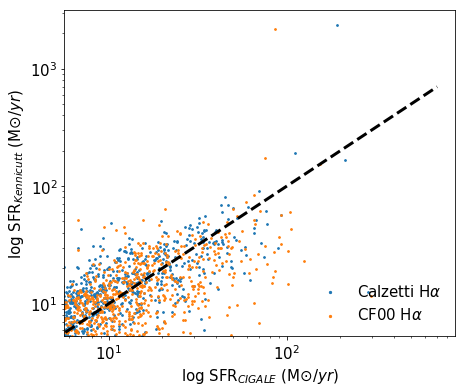

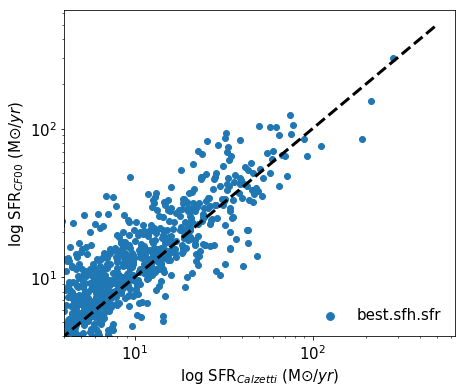

In [198]:
line_2 = np.linspace(0, 700, 100)

plt.figure(figsize=(7,6))
plt.scatter(COSMOS_starburst_results_Ha['best.sfh.sfr'], SFR_kennicutt_98(COSMOS_Halpha_sample_corr_Ha_sb),\
            s = 3, label = r'Calzetti H$\alpha$')
plt.scatter(COSMOS_CF00_results_Ha['best.sfh.sfr'], SFR_kennicutt_98(COSMOS_Halpha_sample_corr_Ha_CF00),\
            s = 3, label = r'CF00 H$\alpha$')
plt.plot(line_2, line_2, ls = '--', lw = 3, c = 'k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'log SFR$_{CIGALE}$ (M$\odot/yr$)', fontsize = 15)
plt.ylabel(r'log SFR$_{Kennicutt}$ (M$\odot/yr$)', fontsize = 15)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'lower right')

plt.figure(figsize=(7,6))
plt.scatter(COSMOS_starburst_results_Ha['best.sfh.sfr'], COSMOS_CF00_results_Ha['best.sfh.sfr'])
plt.plot(line_1, line_1, ls = '--', lw = 3, c = 'k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'log SFR$_{Calzetti}$ (M$\odot/yr$)', fontsize = 15)
plt.ylabel(r'log SFR$_{CF00}$ (M$\odot/yr$)', fontsize = 15)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'lower right')

/home/jvilla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jvilla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


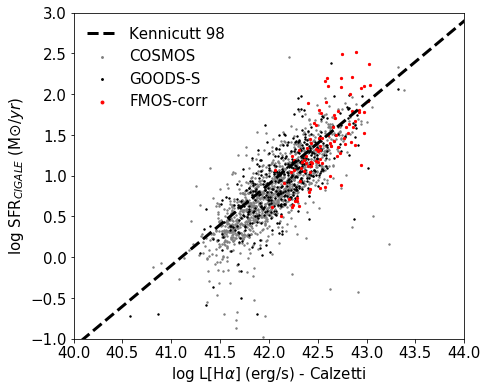

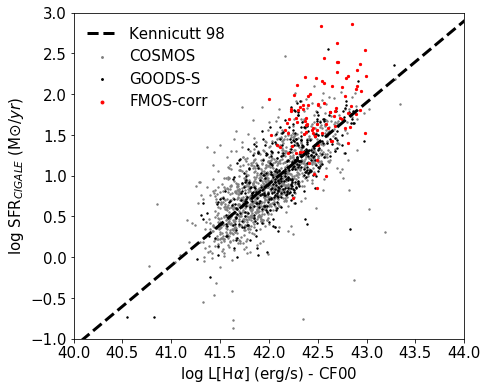

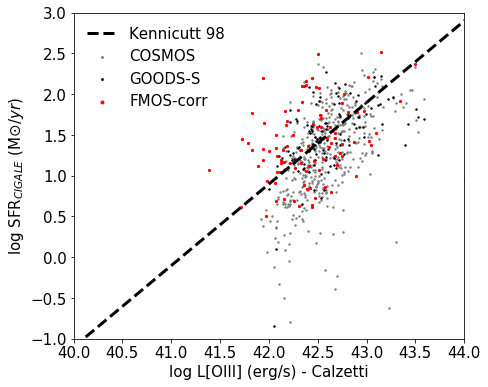

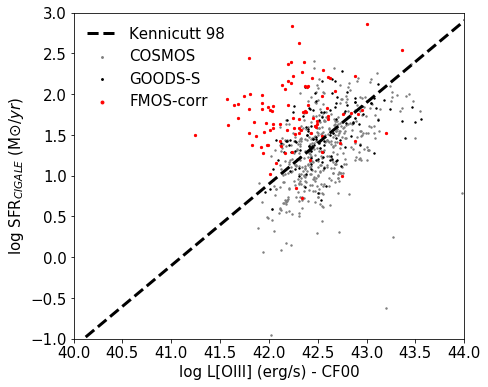

In [163]:
plt.figure(figsize=(7,6))
plt.scatter(np.log10(COSMOS_Halpha_sample_corr_Ha_sb), np.log10(COSMOS_starburst_results_Ha['best.sfh.sfr']),\
            s = 2, c = 'gray', label = 'COSMOS')
plt.scatter(np.log10(GOODSS_Halpha_sample_corr_Ha_sb), np.log10(GOODSS_starburst_results_Ha['best.sfh.sfr']),\
            s = 2, c = 'k', label = 'GOODS-S')
# plt.scatter(np.log10(good_data_Halpha_sample), np.log10(COSMOS_cigale_good_1['best.sfh.sfr']),\
#             s = 5, label = r'L(H$_\alpha$)-nocorr')
plt.scatter(np.log10(good_data_Halpha_sample_sb_corr), np.log10(COSMOS_cigale_good_1['best.sfh.sfr']),\
            s = 5, c = 'red', label = r'FMOS-corr')
plt.plot(np.log10(X_1), np.log10(SFR_kennicutt_98(X_1)), ls = '--', lw = 3, c = 'k', label = 'Kennicutt 98')
plt.ylim(-1, 3)
plt.xlim(40, 44)
plt.xlabel(r'log L[H$\alpha$] (erg/s) - Calzetti', fontsize = 15)
plt.ylabel(r'log SFR$_{CIGALE}$ (M$\odot/yr$)', fontsize = 15)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'upper left')

plt.figure(figsize=(7,6))
plt.scatter(np.log10(COSMOS_Halpha_sample_corr_Ha_CF00), np.log10(COSMOS_CF00_results_Ha['best.sfh.sfr']),\
            s = 2, c = 'gray', label = 'COSMOS')
plt.scatter(np.log10(GOODSS_Halpha_sample_corr_Ha_CF00), np.log10(GOODSS_CF00_results_Ha['best.sfh.sfr']),\
            s = 2, c = 'k', label = 'GOODS-S')
# plt.scatter(np.log10(good_data_Halpha_sample), np.log10(COSMOS_cigale_good_3['best.sfh.sfr']),\
#             s = 5, label = r'L(H$_\alpha$)')
plt.scatter(np.log10(good_data_Halpha_sample_CF00_corr), np.log10(COSMOS_cigale_good_3['best.sfh.sfr']),\
            s = 5, c = 'red', label = r'FMOS-corr')
plt.plot(np.log10(X_1), np.log10(SFR_kennicutt_98(X_1)), ls = '--', lw = 3, c = 'k', label = 'Kennicutt 98')
plt.ylim(-1, 3)Halpha_sample_corr_Ha_CF00
plt.xlim(40, 44)
plt.xlabel(r'log L[H$\alpha$] (erg/s) - CF00', fontsize = 15)
plt.ylabel(r'log SFR$_{CIGALE}$ (M$\odot/yr$)', fontsize = 15)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'upper left')

#-------------------------------------------------------------------------------------------------------------------

plt.figure(figsize=(7,6))
plt.scatter(np.log10(COSMOS_Halpha_sample_corr_OIII_sb), np.log10(COSMOS_starburst_results_OIII['best.sfh.sfr']),\
            s = 2, c = 'gray', label = 'COSMOS')
plt.scatter(np.log10(GOODSS_Halpha_sample_corr_OIII_sb), np.log10(GOODSS_starburst_results_OIII['best.sfh.sfr']),\
            s = 2, c = 'k', label = 'GOODS-S')
# plt.scatter(np.log10(good_data_OIII_sample), np.log10(COSMOS_cigale_good_1['best.sfh.sfr']),\
#             s = 5, label = r'L([OIII])-nocorr')
plt.scatter(np.log10(good_data_OIII_sample_sb_corr), np.log10(COSMOS_cigale_good_1['best.sfh.sfr']),\
            s = 5, c = 'red', label = r'FMOS-corr')
plt.plot(np.log10(X_1), np.log10(SFR_kennicutt_98(X_1)), ls = '--', lw = 3, c = 'k', label = 'Kennicutt 98')
plt.ylim(-1, 3)
plt.xlim(40, 44)
plt.xlabel(r'log L[OIII] (erg/s) - Calzetti', fontsize = 15)
plt.ylabel(r'log SFR$_{CIGALE}$ (M$\odot/yr$)', fontsize = 15)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'upper left')

plt.figure(figsize=(7,6))
plt.scatter(np.log10(COSMOS_Halpha_sample_corr_OIII_CF00), np.log10(COSMOS_CF00_results_OIII['best.sfh.sfr']),\
            s = 2, c = 'gray', label = 'COSMOS')
plt.scatter(np.log10(GOODSS_Halpha_sample_corr_OIII_CF00), np.log10(GOODSS_CF00_results_OIII['best.sfh.sfr']),\
            s = 2, c = 'k', label = 'GOODS-S')
# plt.scatter(np.log10(good_data_OIII_sample), np.log10(COSMOS_cigale_good_3['best.sfh.sfr']),\
#             s = 5, label = r'L([OIII])-nocorr')
plt.scatter(np.log10(good_data_OIII_sample_CF00_corr), np.log10(COSMOS_cigale_good_3['best.sfh.sfr']),\
            s = 5, c = 'red', label = r'FMOS-corr')
plt.plot(np.log10(X_1), np.log10(SFR_kennicutt_98(X_1)), ls = '--', lw = 3, c = 'k', label = 'Kennicutt 98')
plt.ylim(-1, 3)
plt.xlim(40, 44)
plt.xlabel(r'log L[OIII] (erg/s) - CF00', fontsize = 15)
plt.ylabel(r'log SFR$_{CIGALE}$ (M$\odot/yr$)', fontsize = 15)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'upper left')

# Fitting [OIII] to retrieve a SFR-[OIII] correlation

In [297]:
test_1 = [COSMOS_OIII_sample*10**(0.4*A_Ha_starburst), np.array(COSMOS_starburst_results['best.sfh.sfr'])]
X = test_1[0][test_1[0] > 0]
y = test_1[1][test_1[0] > 0]
X = X.reshape(-1, 1)

reg = LinearRegression().fit(X, y)

print(reg.score(X, y))
print(reg.coef_)
print(reg.intercept_) 
print(np.log10(reg.coef_[0]), np.log10(reg.intercept_))

0.007323289382439313
[7.21716785e-44]
38.04414297559683
-43.14163319394936 1.5802878051493727


In [300]:
COSMOS_CF00_results_good = COSMOS_CF00_results[COSMOS_CF00_results['best.sfh.sfr'] > 0]
COSMOS_OIII_sample_good  = COSMOS_OIII_sample[COSMOS_CF00_results['best.sfh.sfr'] > 0]

test_2 = [COSMOS_OIII_sample_good*10**(0.4*A_Ha_CF00), np.array(COSMOS_CF00_results_good['best.sfh.sfr'])]
X = test_2[0][test_2[0] > 0]
y = test_2[1][test_2[0] > 0]
X = X.reshape(-1, 1)

reg = LinearRegression().fit(X, y)

print(reg.score(X, y))
print(reg.coef_)
print(reg.intercept_) 
print(np.log10(reg.coef_[0]), np.log10(reg.intercept_))

7.701176806096388e-05
[2.58281924e-44]
13.631692167179413
-43.587905986977795 1.134549770233304


In [301]:
COSMOS_OIII_new  = flux_to_luminosity(flux=COSMOS_sample['line.OIII-500.7'], z=COSMOS_sample['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)
GOODSS_OIII_new  = flux_to_luminosity(flux=GOODSS_sample['line.OIII-500.7'], z=GOODSS_sample['redshift'], Om=Om, Ol=Ol, c=c, H0=H0)


SFR_OIII_COSMOS = 10**(-43.587905986977795)*(COSMOS_OIII_new**1.134549770233304)
SFR_OIII_GOODSS = 10**(-43.587905986977795)*(GOODSS_OIII_new**1.134549770233304)

SFR_OIII_COSMOS_1 = 10**(-43.14163319394936)*(COSMOS_OIII_new**1.5802878051493727)
SFR_OIII_GOODSS_1 = 10**(-43.14163319394936)*(GOODSS_OIII_new**1.5802878051493727)

/home/jvilla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """
/home/jvilla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in power
  
/home/jvilla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in power
  
/home/jvilla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


/home/jvilla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/jvilla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/jvilla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/home/jvilla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


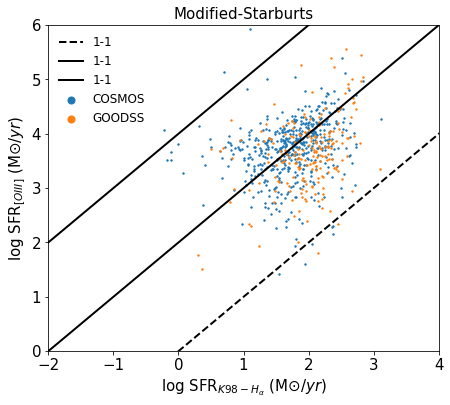

In [309]:
X_new = np.linspace(-2, 7, 10)

plt.figure(figsize = (7,6))
plt.scatter(np.log10(SFR_kennicutt_98_corrected(COSMOS_Halpha_sample, A_Ha_starburst)/ratio_NII_halpha), np.log10(SFR_OIII_COSMOS), s = 2, label = 'COSMOS')
plt.scatter(np.log10(SFR_kennicutt_98_corrected(GOODSS_Halpha_sample, A_Ha_starburst)/ratio_NII_halpha), np.log10(SFR_OIII_GOODSS), s = 2, label = 'GOODSS')
# plt.scatter(np.log10(SFR_kennicutt_98_corrected(COSMOS_Halpha_sample, A_Ha_starburst)/ratio_NII_halpha), np.log10(SFR_OIII_COSMOS_1), s = 2, label = r'H$_\alpha$ observed-corrected by average')
# plt.scatter(np.log10(SFR_kennicutt_98_corrected(GOODSS_Halpha_sample, A_Ha_starburst)/ratio_NII_halpha), np.log10(SFR_OIII_GOODSS_1), s = 2, label = r'H$_\alpha$ observed-corrected by average')
plt.plot(X_new, X_new, ls = '--', lw = 2, c = 'k', label = '1-1')
plt.plot(X_new - 1, X_new + 1, ls = '-', lw = 2, c = 'k', label = '1-1')
plt.plot(X_new - 2, X_new + 2, ls = '-', lw = 2, c = 'k', label = '1-1')
plt.xlim(-2, 4)
plt.ylim(0, 6)
plt.xlabel(r'log SFR$_{K98-H_\alpha}$ (M$\odot/yr$)', fontsize = 15)
plt.ylabel(r'log SFR$_{[OIII]}$ (M$\odot/yr$)', fontsize = 15)
plt.title('Modified-Starburts', fontsize = 15)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.legend(frameon = False, prop = {'size': 12}, markerscale = 5 , loc = 'upper left')